# LGBIO2072: Project 2 - Q1 & Bonus
#### Matthew Lambrechts (22232000) 
#### Nora De Vleeschouwer (48602100)

## Imports

In [53]:
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

## Load files of folder "dataNeuron" and store them in a dictionary

In [54]:
def loadNeuron():
    
    namesSignals= [
        ('time'    ),
        ('shoang'  ),
        ('elbang'  ),
        ('handxpos'),
        ('handypos'),
        ('cells'   )]
    
    dictNeurons = {}
    for targetNum in range(1,9):
            
        target = {}
            
        for trialNum in range(1,7):
            trial = {}
            for nam in namesSignals:
                key = nam
                value = spio.loadmat('dataNeuron/target'+str(targetNum)+'trial' + str(trialNum) + 'signals'+nam+'.mat')
                trial[key]=value['a']
                
            target['trial'+str(trialNum)] = trial
    
        dictNeurons['target'+str(targetNum)] = target
        
    return dictNeurons
    
dictNeurons = loadNeuron()

## Q1

### Info about dataset

- dictNeurons contains 8 dictionaries with kinematic and neural data from reaching movements towards eight different targets
- 6 trials per target
- recorded data per trial: time, shoang, elbang, handxpos, handypos, cells
- Data was sampled at 200 Hz => dt = 1000/199 , in milliseconds
- cells: binary vector, 1 binary number per time level, 1 if neuron emitted a spike and 0 otherwise

In [55]:
targets = dictNeurons.keys()
print(targets)

trials = dictNeurons["target1"].keys()
print(trials)

quantities = dictNeurons["target1"]["trial1"].keys()
print(quantities)

# The 6 trials of one experiment haven't the same timespan
for i in range(6):
    trial = "trial" + str(i+1)
    times = dictNeurons["target1"][trial]["time"].ravel()
    print(f"time of experiment 1, trial {i+1}:", times[len(times) -1] - times[0], "[ms],", times.ravel().shape)

dict_keys(['target1', 'target2', 'target3', 'target4', 'target5', 'target6', 'target7', 'target8'])
dict_keys(['trial1', 'trial2', 'trial3', 'trial4', 'trial5', 'trial6'])
dict_keys(['time', 'shoang', 'elbang', 'handxpos', 'handypos', 'cells'])
time of experiment 1, trial 1: 4145 [ms], (830,)
time of experiment 1, trial 2: 4725 [ms], (946,)
time of experiment 1, trial 3: 4080 [ms], (817,)
time of experiment 1, trial 4: 4110 [ms], (823,)
time of experiment 1, trial 5: 4105 [ms], (822,)
time of experiment 1, trial 6: 4475 [ms], (896,)


### Plot all the interesting graphs for each target

For each target, each trial has a different timespan. \
Hence, we can't just take a common time interval to each trial as the movements occur at different times. \
For each target, we must choose a threshold for a chosen quantity to determine the timespan on which we compute the means. \
All the experiments last on average ~ 4 [s] but the movements last on average ~ 1 [s]. \
Hence, for all experiments, we consider a time interval of only 1 [s] where the time levels are sampled at 200 [Hz] as for the data. \
Finally, for each target, we obtain one averaged graph for each of the 5 quantities.

In [56]:
# Names of targets and trials
targets = ["target1","target2", "target3", "target4", "target5", "target6", "target7", "target8"]
trials = ["trial1", "trial2", "trial3", "trial4", "trial5", "trial6"]

# Considered time interval for all experiments, sampled at 200 [Hz] like the data
# The experiments last ~ 4 [s] = 4000 [ms]
# Only 1 [s] = 1000 [ms] is important because the reaching movements are short, ~ 6 [cm] = 60 [mm]
# We see on the plots of the quantities that the signals last ~ 1 [s] = 1000 [ms]
time_of_interest = np.linspace(0, 1000, 200)

# Thresholds for each target to determine the timespan of interest
thresholds = [25, 20, 0.9, 1, 1.7, 1.9, 1.7, 0.7]

# Quantities on which we apply the threshold for each target
quantities = ["handxpos", "handxpos", "shoang", "shoang", "elbang", "elbang", "elbang", "shoang"]

# The time step is related to the sample frequency 200 [Hz]: dt = 1000/199 [ms]
# There are 199 subintervals for 1 [s] = 1000 [ms]
dt = 1000/199

# k(t) = (1/dt) * 1_{0 <= t <= dt}
# Needed to compute the firing rate of the spike train "cells"
kernel = (1/dt) * np.ones(2)

# Colors used for plots
# Blue: "#1f77b4" Orange: "#ff7f0e" Green: "#2ca02c" Red: "#d62728" Purple: "#9467bd" Brown: "#8c564b" Pink: "#e377c2" Gray: "#7f7f7f" 
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f" ]

# Mean final hand positions for each target experiment ~ Targets
targets_x = np.zeros(8)
targets_y = np.zeros(8)

# Mean initial hand positions for each target experiment
initial_hands_x = np.zeros(8)
initial_hands_y = np.zeros(8)

# Mean spike counts for each target experiment
spike_counts = np.zeros(8)

# Mean hand trajectories for each target experiment
handxposs = np.zeros((8, 200))
handyposs = np.zeros((8, 200))

In [57]:
def firing_rate(spike_train):
	"""
	Compute the firing rate with the rectangular kernel.

	Spike count in sliding interval of size dt. Histogram of spike count (PSTH).
	"""
	# Compute the firing rate using a sliding window
	firing_rate = np.convolve(kernel, spike_train, mode='same')

	return firing_rate

In [58]:
def plot_quantities(time, rho, shoang, elbang, handxpos, handypos, target_idx, trial_idx = None):
	"""
	If trial_idx = None, 
	Plot the mean of the 5 quantities and the hand trajectory associated to the given target.
	Store the mean initial and final hand positions in initial_hands_x, initial_hands_y, targets_x, targets_y.
	Else,
	Plot the 5 quantities and the hand trajectory associated to the given target and trial.
	"""
	# 1 Figure
	fig = plt.figure(figsize = (12,8))

	# 6 Subfigures
	ax1 = plt.subplot2grid((5, 6), (0, 0), colspan = 3)
	ax2 = plt.subplot2grid((5, 6), (1, 0), colspan = 3)
	ax3 = plt.subplot2grid((5, 6), (2, 0), colspan = 3)
	ax4 = plt.subplot2grid((5, 6), (3, 0), colspan = 3)
	ax5 = plt.subplot2grid((5, 6), (4, 0), colspan = 3)
	ax6 = plt.subplot2grid((5, 6), (0, 3), rowspan=5, colspan = 3)

	# Subfigure 1: rho (firing rate)
	ax1.plot(time, rho)
	ax1.set_ylabel("firing rate [1/ms]")
	ax1.grid()

	# Subfigure 2: shoang
	ax2.plot(time, shoang)
	ax2.set_ylabel("shoulder angle [rad]")
	ax2.grid()

	# Subfigure 3: elbang
	ax3.plot(time, elbang)
	ax3.set_ylabel("elbow angle [rad]")
	ax3.grid()

	# Subfigure 4: handxpos
	ax4.plot(time, handxpos)
	ax4.set_ylabel("hand $x$ [mm]")
	ax4.grid()

	# Subfigure 5: handypos
	ax5.plot(time, handypos)
	ax5.set_xlabel("time [ms]")
	ax5.set_ylabel("hand $y$ [mm]")
	ax5.grid()

	# Subfigure 6: (handxpos, handypos)

	# Plot the initial and final setups and the trajectory of the monkey's hand

	# Initial position of hand
	ax6.scatter(handxpos[0], handypos[0], c = "g", label = f"initial hand ({handxpos[0]:.3f}, {handypos[0]:.3f})")

	# Final position of hand
	final_time_level = len(time) - 1
	ax6.scatter(handxpos[final_time_level], handypos[final_time_level], c = "r", label = f"final hand ({handxpos[final_time_level]:.3f}, {handypos[final_time_level]:.3f})")

	# State-space orbit // Hand trajectory
	ax6.plot(handxpos, handypos, linestyle = "--", label = "hand trajectory")

	ax6.set_xlabel("$x$ [mm]") ; ax6.set_ylabel("$y$ [mm]")
	ax6.axis("equal")
	ax6.grid()
	ax6.legend()

	# Adjust subplot spacing to prevent label overlap
	plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

	plt.tight_layout()
	
	# If we didn't specify the trial, then we are computing the means
	if trial_idx == None:
		initial_hands_x[target_idx] = handxpos[0] ; initial_hands_y[target_idx] = handypos[0]
		targets_x[target_idx] = handxpos[final_time_level] ; targets_y[target_idx] = handypos[final_time_level]
		# plt.savefig(f"plots/{targets[target_idx]}/{targets[target_idx]}_mean.pdf")
	else:
		# plt.savefig(f"plots/{targets[target_idx]}/{targets[target_idx]}_{trials[trial_idx]}.pdf")
		pass
		
	plt.show()

In [59]:
def plot_spike_train(time, cells, target_idx, trial_idx):
    """
    Plot the spike train for the given target and trial to verify the mean spike count for the given target.
    """
    plt.plot(time, cells)
    plt.xlabel("time [ms]") ; plt.ylabel("spike")
    
    # plt.savefig(f"plots/{targets[target_idx]}/{targets[target_idx]}_{trials[trial_idx]}_cells.pdf")
    
    plt.show()

In [60]:
def plot_experiments():
	"""
	Plot the 5 quantities and the hand trajectory for all the targets and trials.
	Plot the mean of the 5 quantities and the hand trajectory for all the targets.
	Store the mean initial and final hand positions in initial_hands_x, initial_hands_y, targets_x, targets_y.
	Plot separately the spike trains for all the targets and trials.
	Store the mean spike counts in spike_counts.
	Store the mean hand trajectories in handxposs, handyposs.
	"""
	# For each target
	for i in range(8):
		# Create directory to store the plots associated to the current target
		directory_path = Path(f"plots/{targets[i]}")

		# Check if the path exists
		if not directory_path.exists():
			directory_path.mkdir()
		
		# Threshold for current target
		threshold = thresholds[i]
		
		# Quantity on which we apply the threshold for current target
		quantity = quantities[i]
		
		# Means of the quantities over the trials for each time level of interest for current target
		rho_mean = np.zeros(200)
		shoang_mean = np.zeros(200)
		elbang_mean = np.zeros(200)
		handxpos_mean = np.zeros(200)
		handypos_mean = np.zeros(200)

		# Mean spike count over the trials for current target
		spike_count_mean = 0
		
		# For each trial 
		for j in range(6):
			# Find the index at which the quantity reaches the threshold
			threshold_idx = 0
			for idx, value in enumerate(dictNeurons[targets[i]][trials[j]][quantity].ravel()):
				if value >= threshold:
					threshold_idx = idx
					break
			
			# The points are sampled at 200 [Hz] = 200 pts/1000 [ms] = 100 pts/500 [ms]
			# This means that one time segment of 500 [ms] contains 100 pts
			# Hence, if I am at some point and want to go 500 [ms] forward/backward, I must go 99 pts to the right/left
			idx_start = threshold_idx - 99
			idx_stop = threshold_idx + 99
			
			# 5 Quantities
			cells = dictNeurons[targets[i]][trials[j]]["cells"].ravel()
			shoang = dictNeurons[targets[i]][trials[j]]["shoang"].ravel()
			elbang = dictNeurons[targets[i]][trials[j]]["elbang"].ravel()
			handxpos = dictNeurons[targets[i]][trials[j]]["handxpos"].ravel()
			handypos = dictNeurons[targets[i]][trials[j]]["handypos"].ravel()
			
			# Compute firing rate
			rho = firing_rate(cells)
			
			# Build quantity vectors associated to time_of_interest
			cells_of_interest = cells[idx_start - 1 : idx_stop + 1]
			rho_of_interest = rho[idx_start - 1 : idx_stop + 1]
			shoang_of_interest = shoang[idx_start - 1 : idx_stop + 1]
			elbang_of_interest = elbang[idx_start - 1 : idx_stop + 1]
			handxpos_of_interest = handxpos[idx_start - 1 : idx_stop + 1]
			handypos_of_interest = handypos[idx_start - 1 : idx_stop + 1]
			
			# Add those vectors progressively to the mean vectors
			rho_mean += rho_of_interest
			shoang_mean += shoang_of_interest
			elbang_mean += elbang_of_interest
			handxpos_mean += handxpos_of_interest
			handypos_mean += handypos_of_interest

			# Plot all the interesting graphs for the current target and trial
			plot_quantities(time_of_interest, rho_of_interest, shoang_of_interest, elbang_of_interest, 
							handxpos_of_interest, handypos_of_interest, i, j)
			
			# Plot the spike train for the current target and trial
			plot_spike_train(time_of_interest, cells_of_interest, i, j)

			# Add the spike count progressively to the mean spike count
			# Count the number of non-zero elements in the spike train as the spikes have not always "1" as value, "2" might occur as well
			spike_count_mean += np.count_nonzero(cells_of_interest)
		
		# Finalize means
		rho_mean /= 6
		shoang_mean /= 6
		elbang_mean /= 6
		handxpos_mean /= 6
		handypos_mean /= 6
		spike_count_mean /= 6

		# Store mean spike count in spike_counts
		spike_counts[i] = spike_count_mean

		# Store mean hand trajectory in handxposs, handyposs
		handxposs[i] = handxpos_mean ; handyposs[i] = handypos_mean
		
		# Plot all the interesting graphs for the current target where the quantities are averaged over the 6 trials
		plot_quantities(time_of_interest, rho_mean, shoang_mean, elbang_mean, handxpos_mean, handypos_mean, i)

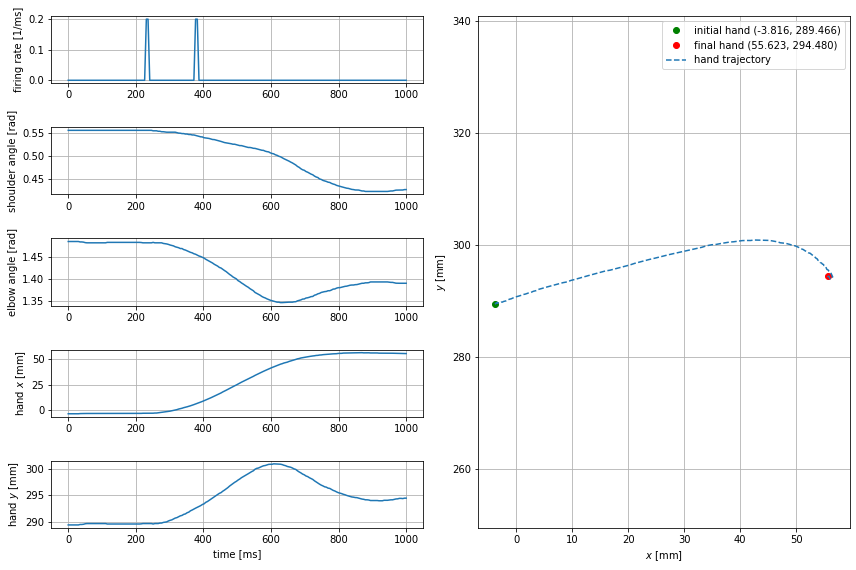

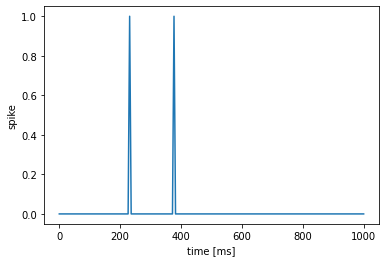

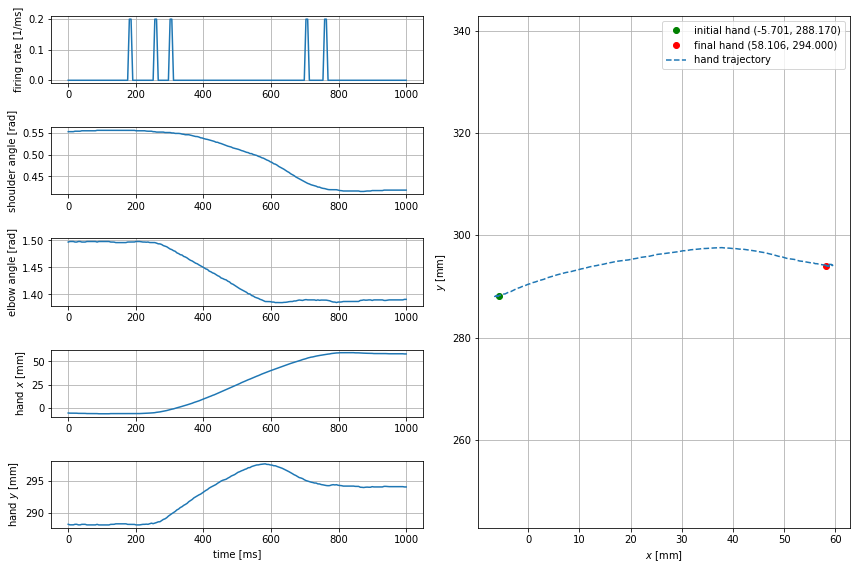

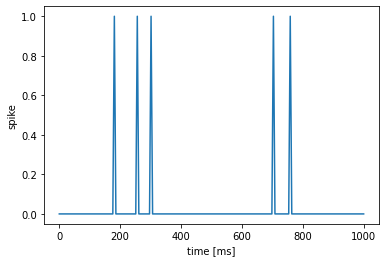

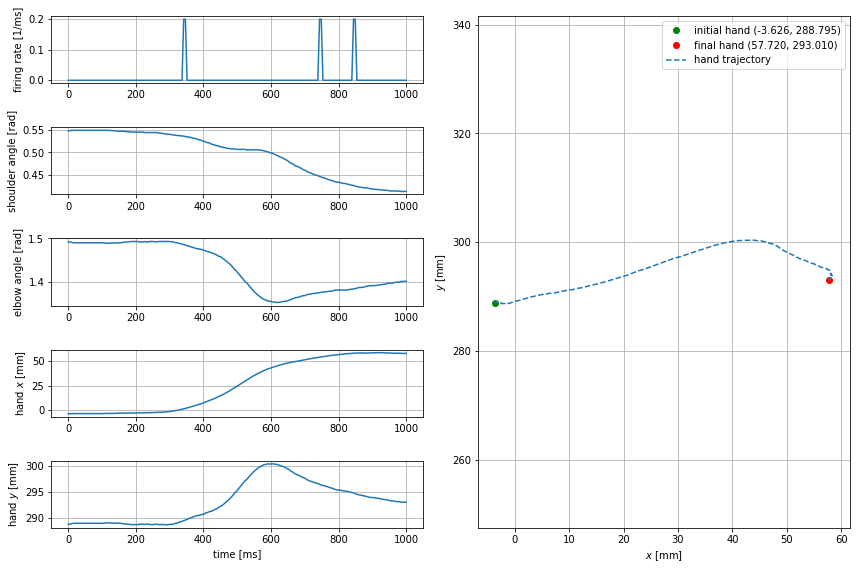

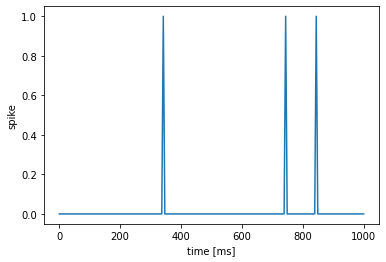

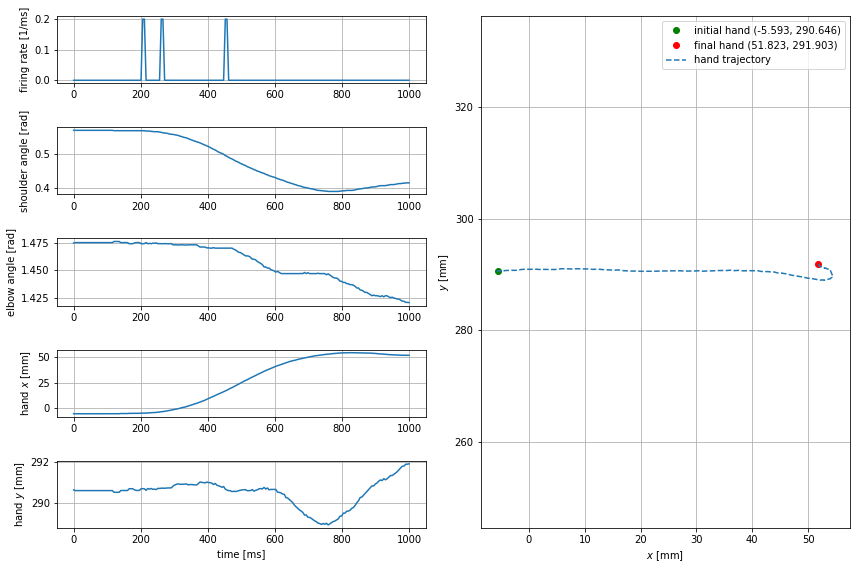

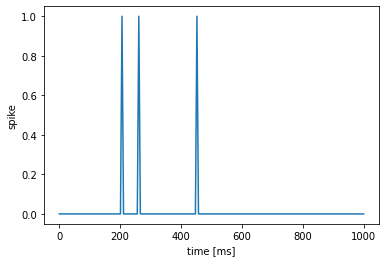

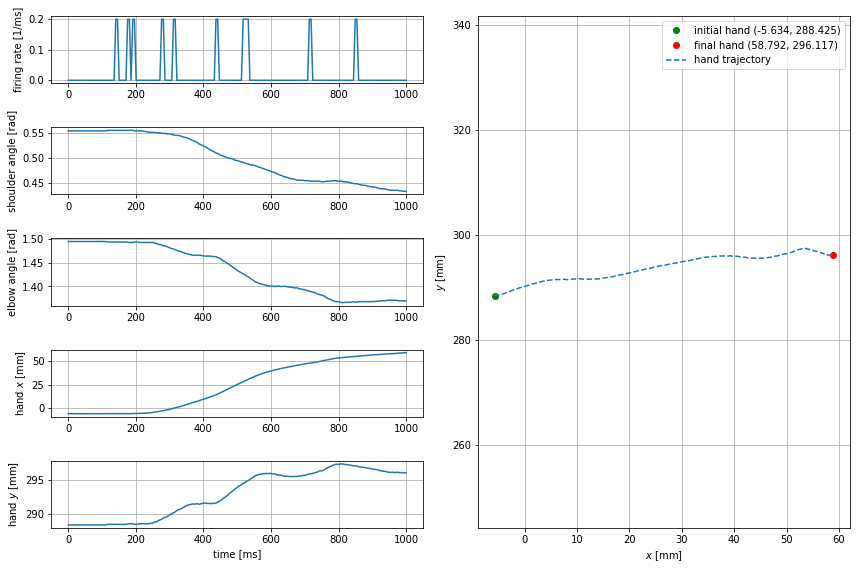

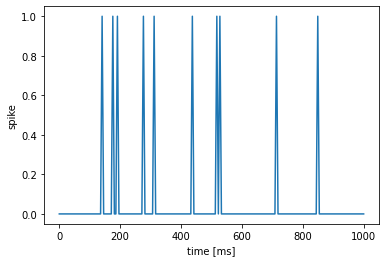

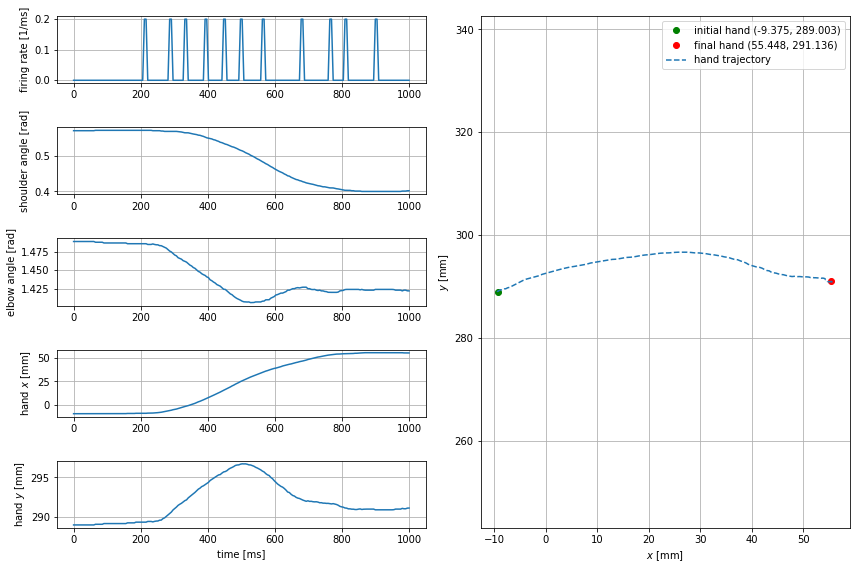

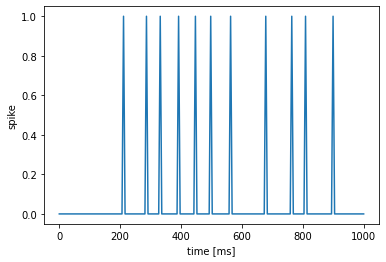

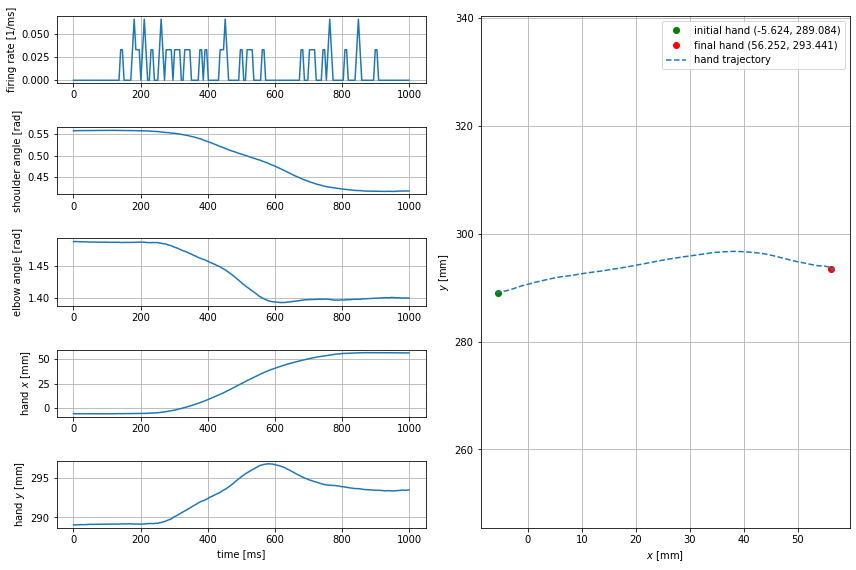

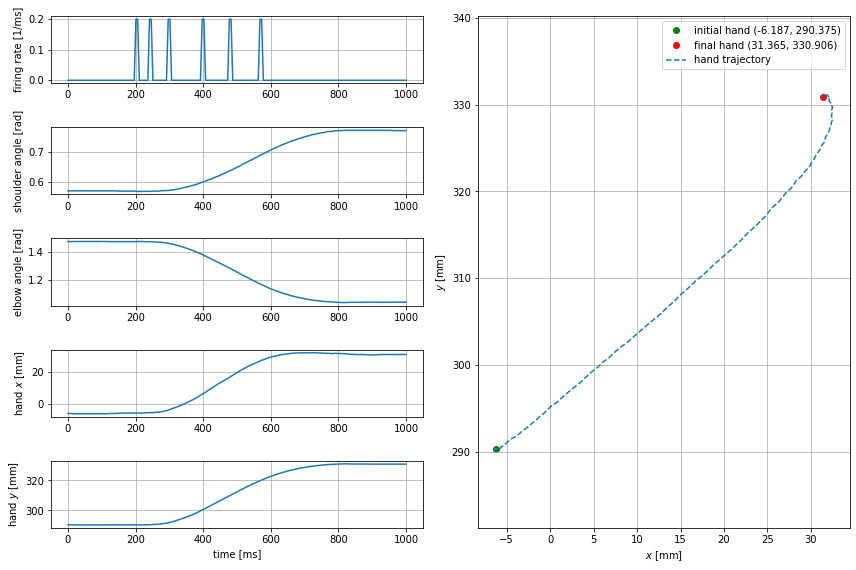

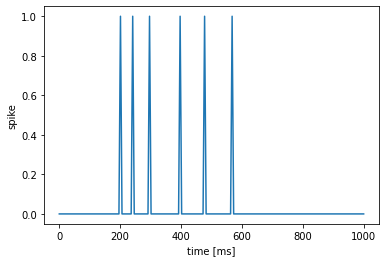

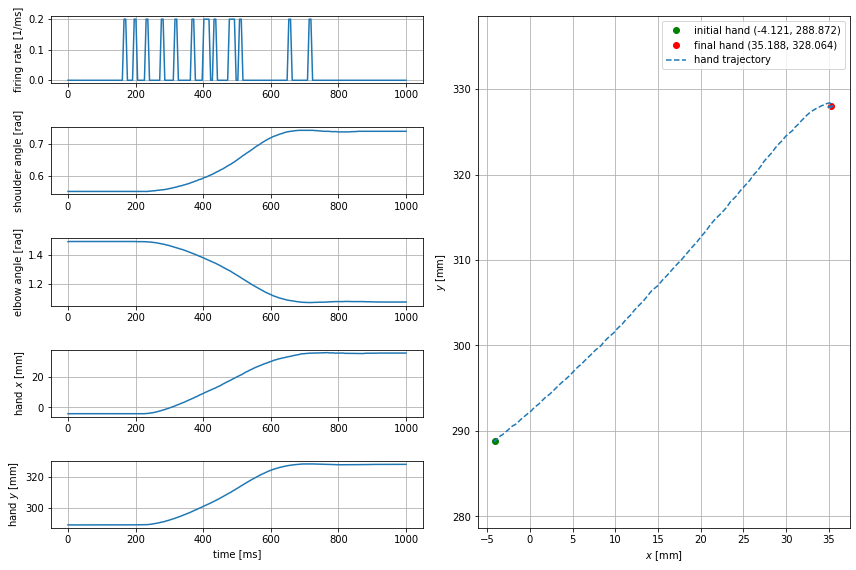

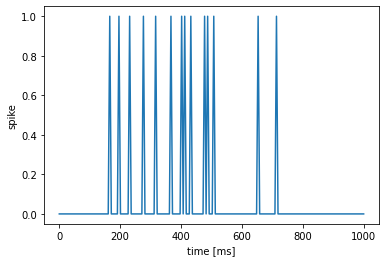

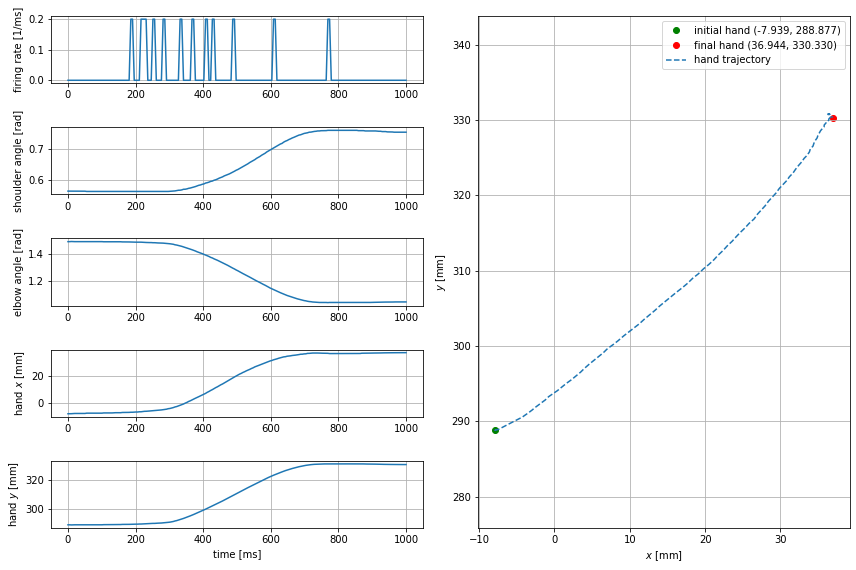

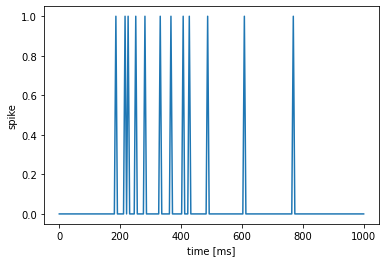

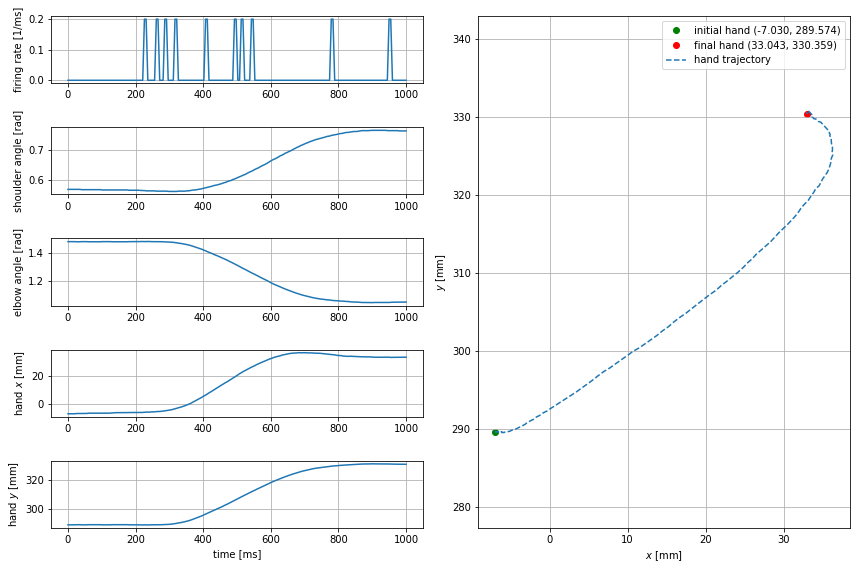

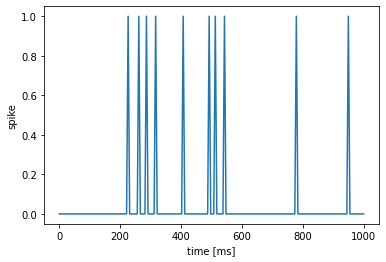

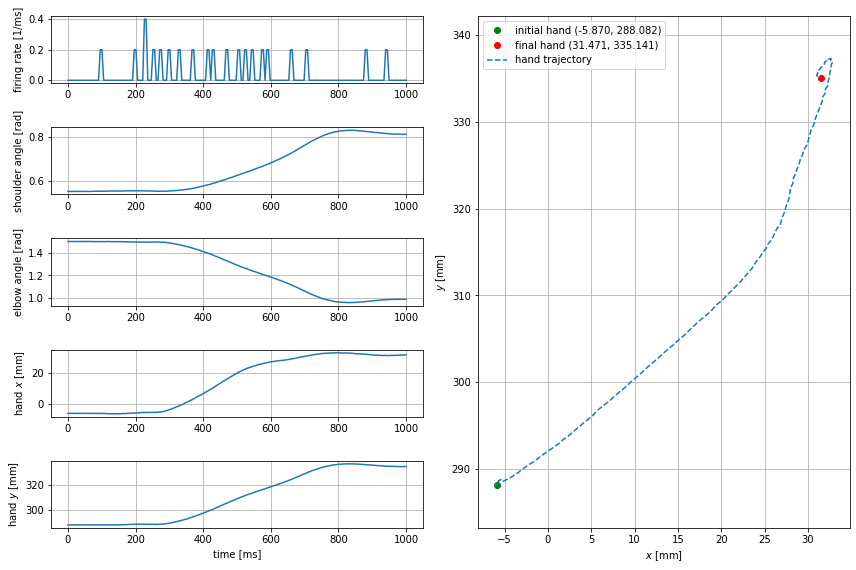

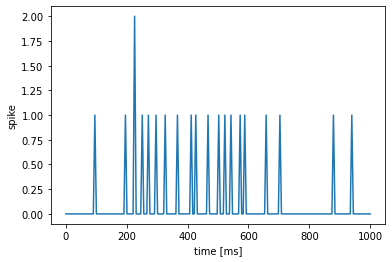

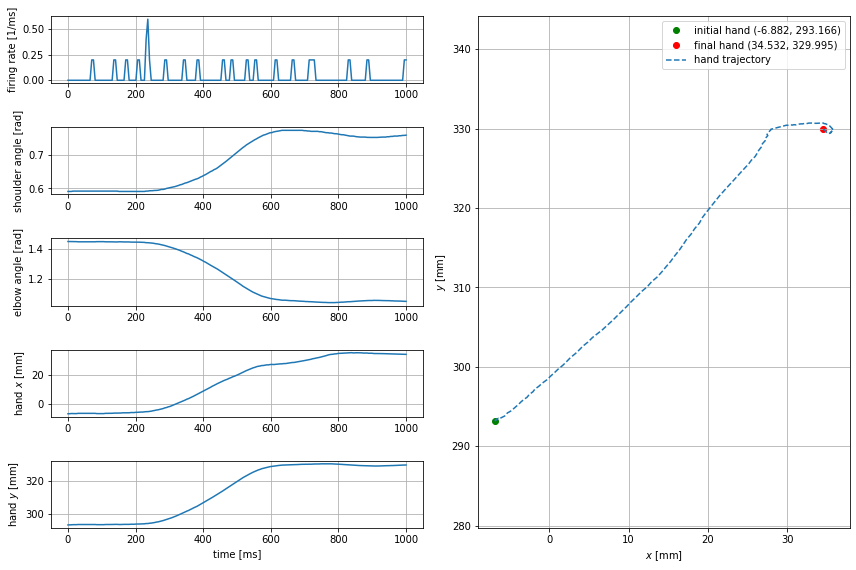

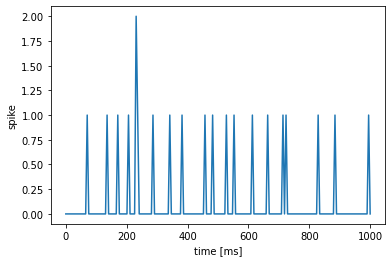

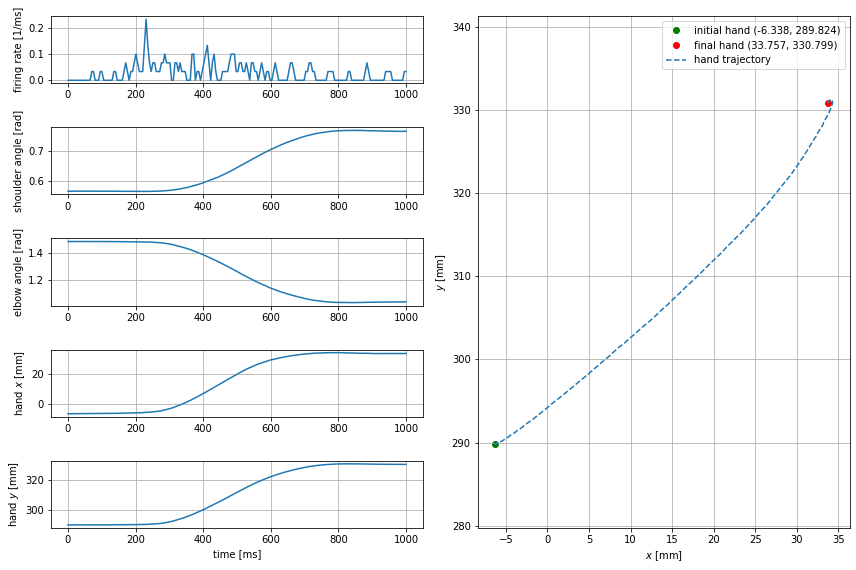

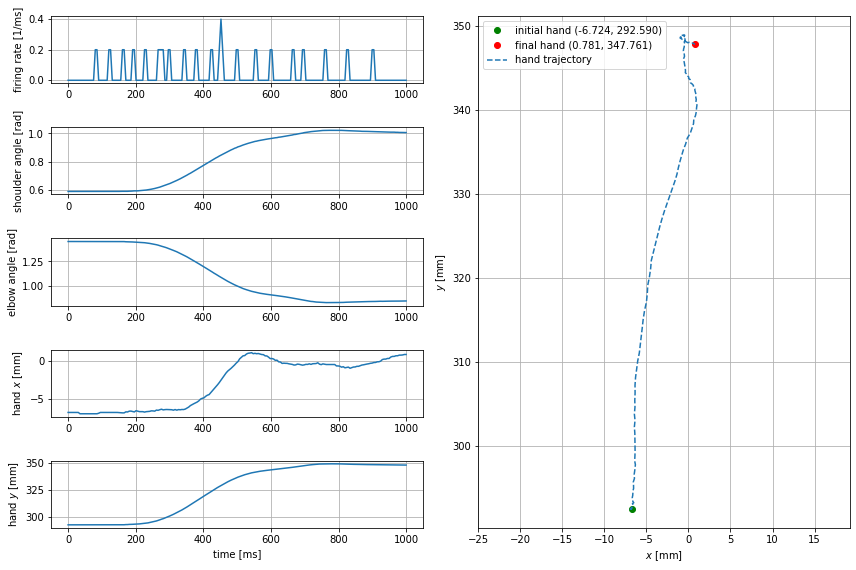

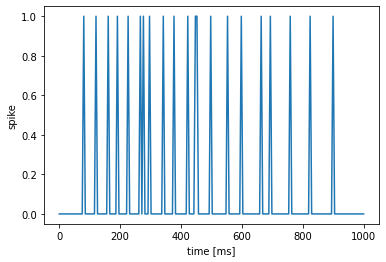

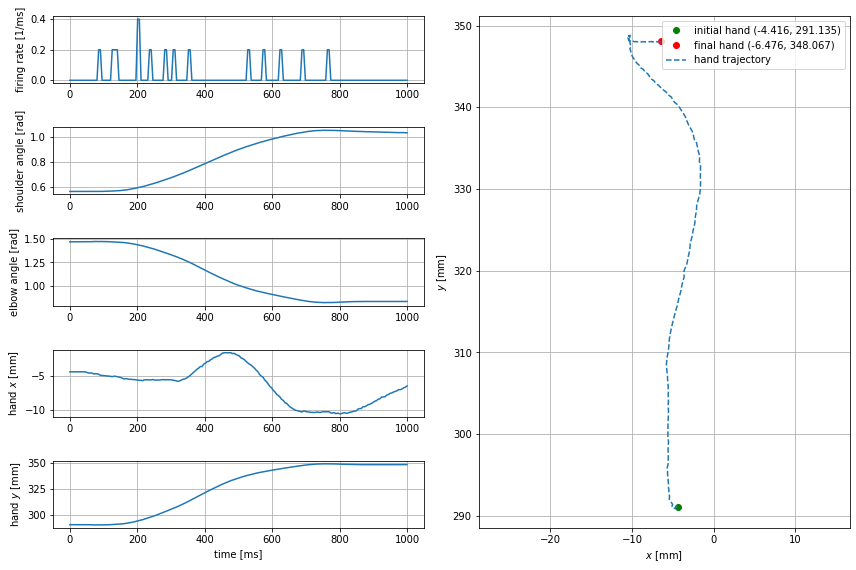

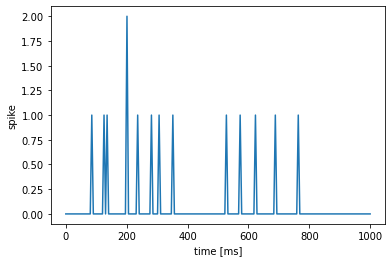

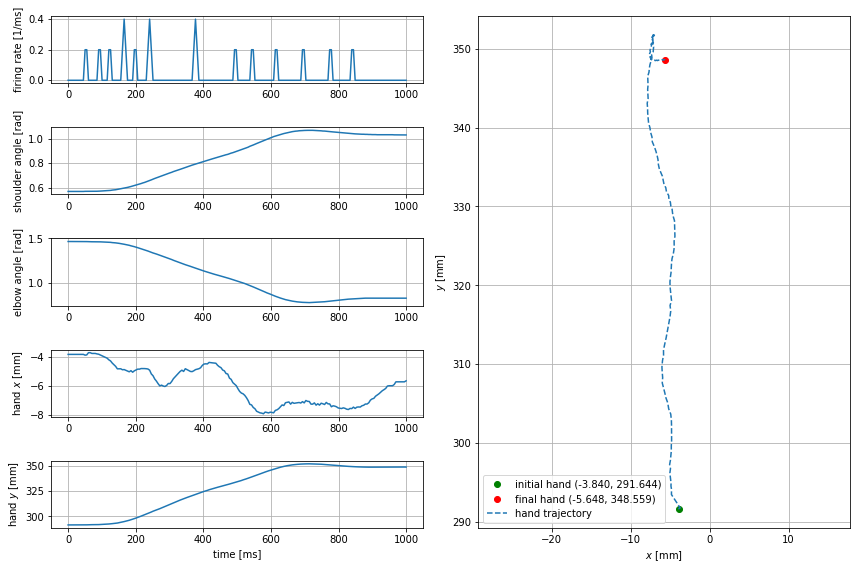

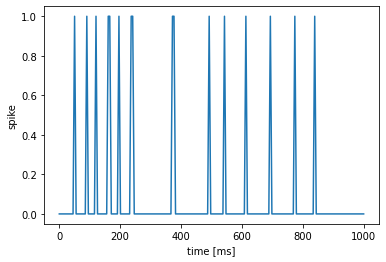

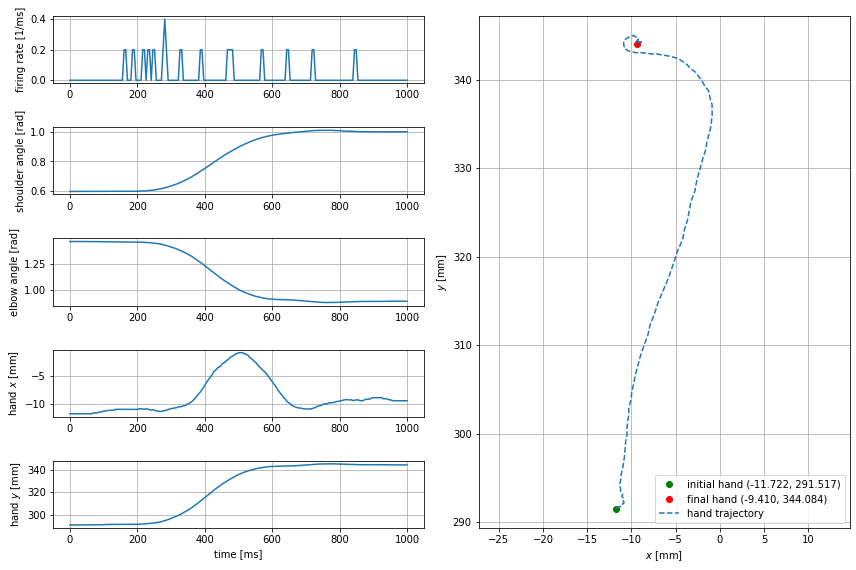

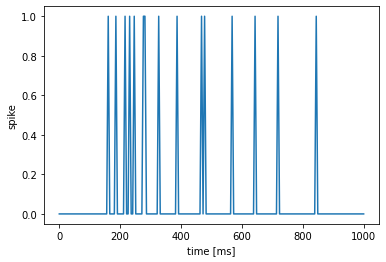

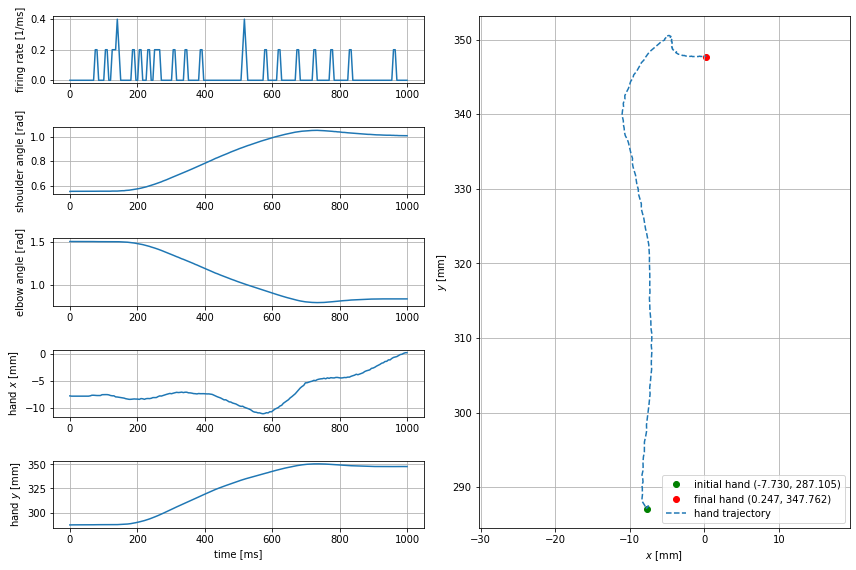

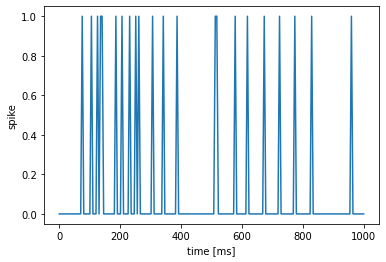

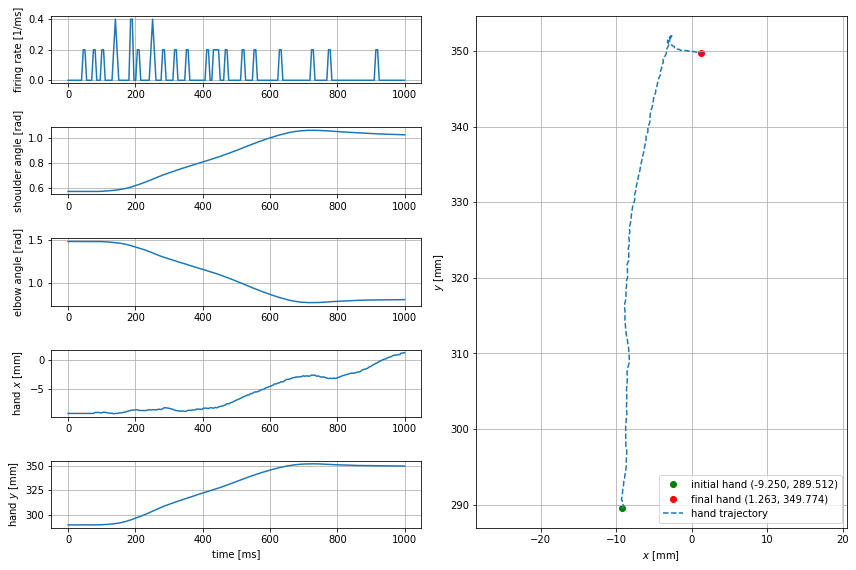

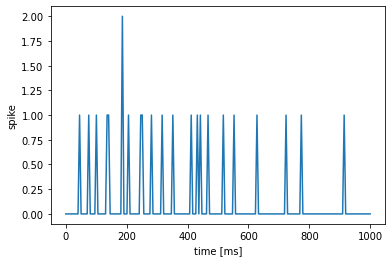

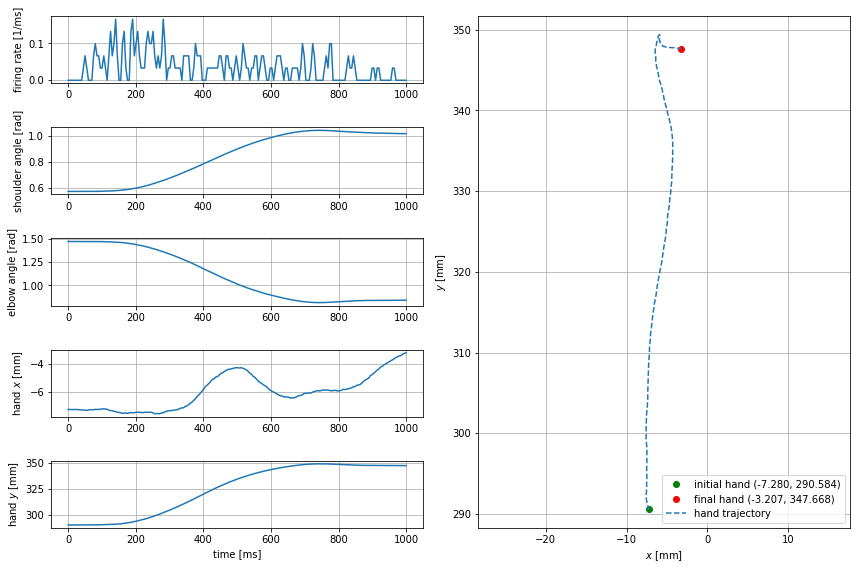

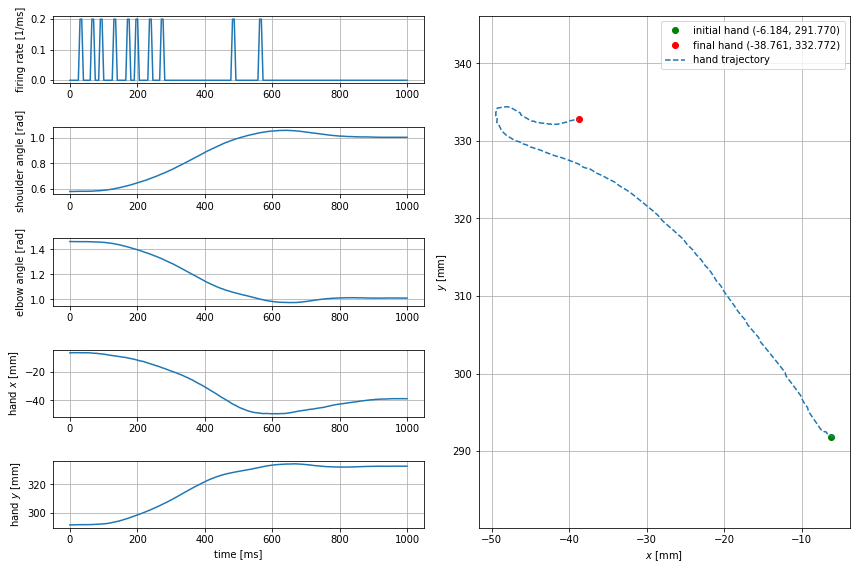

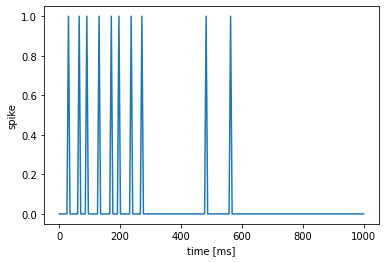

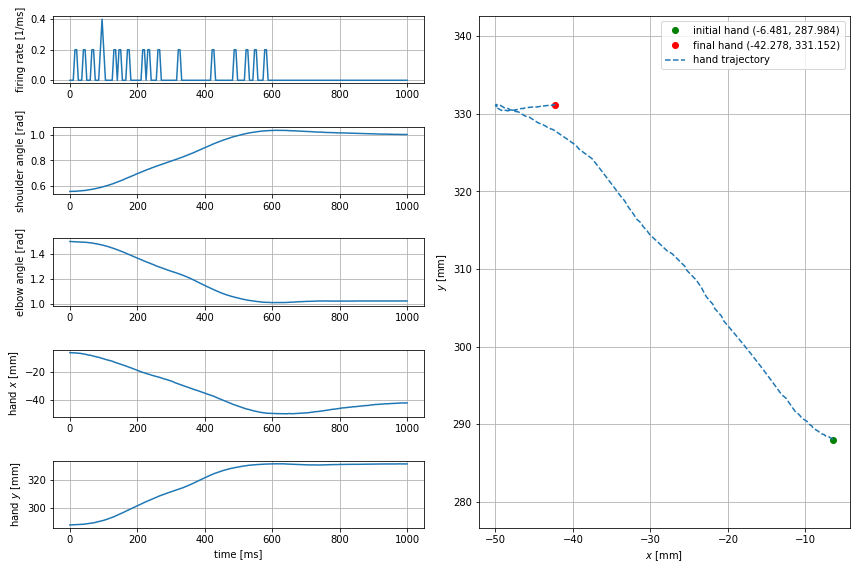

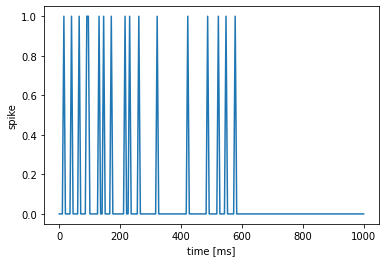

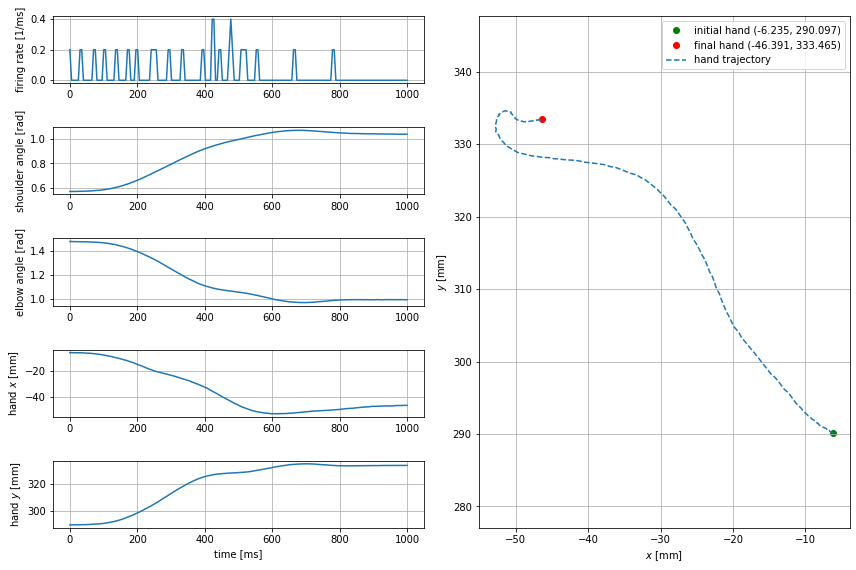

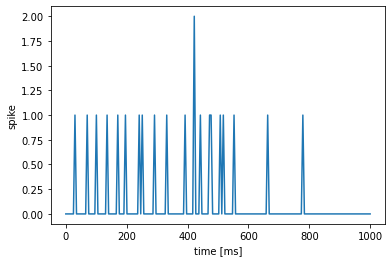

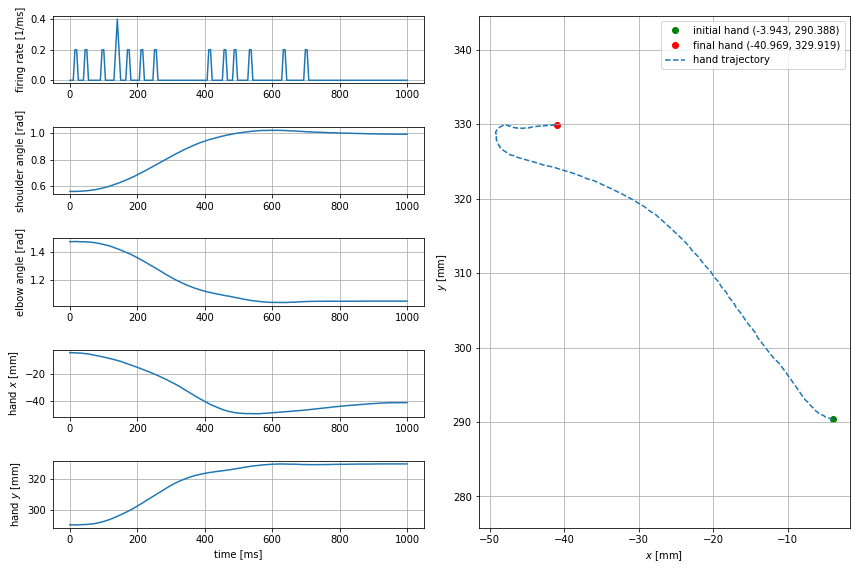

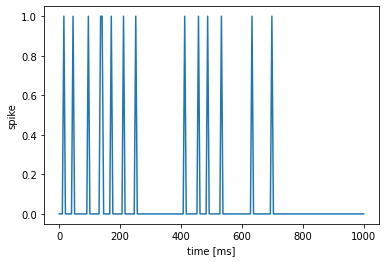

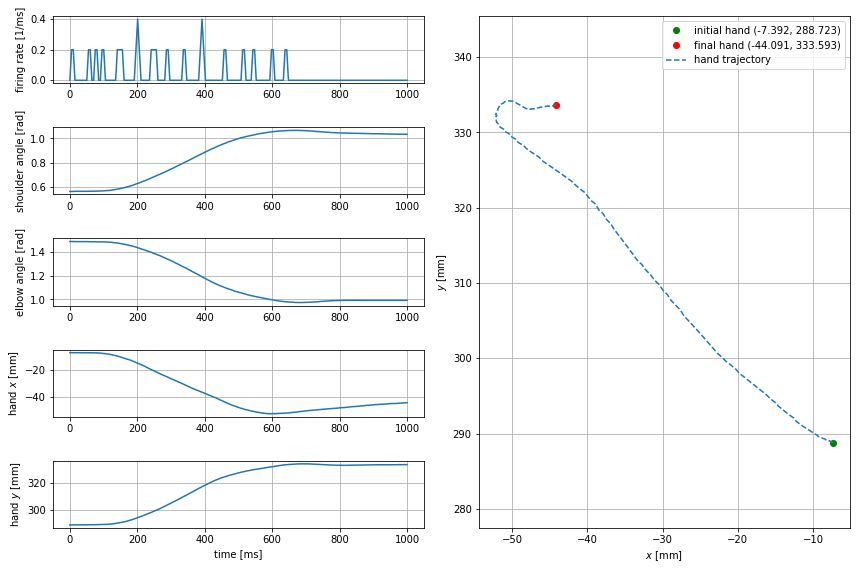

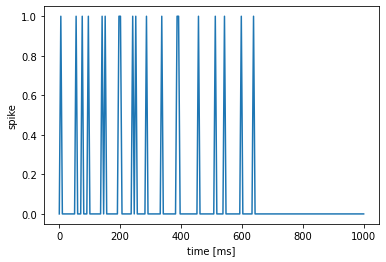

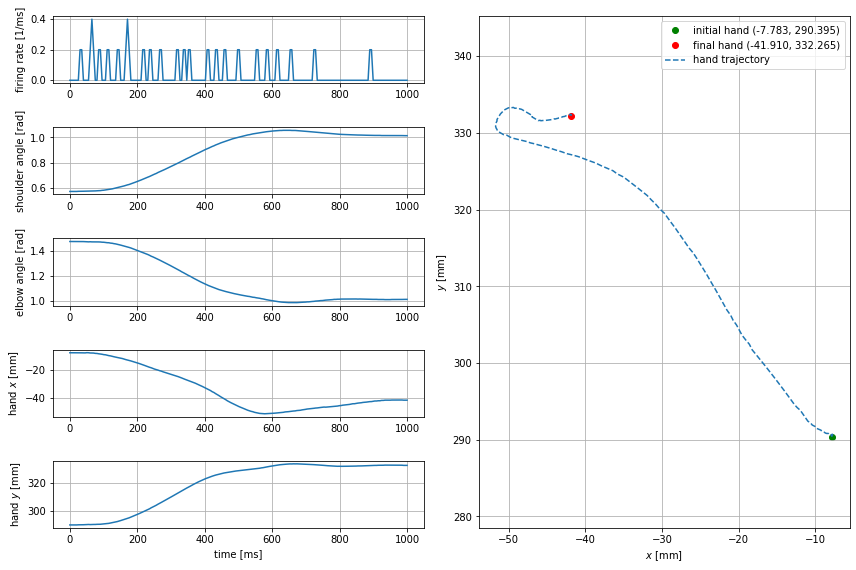

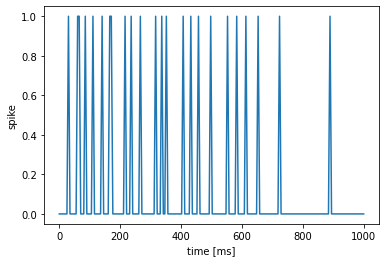

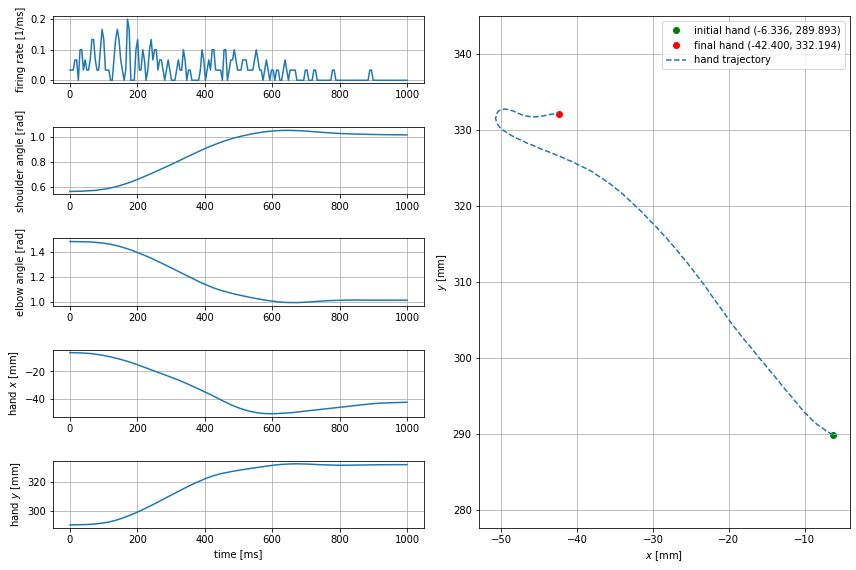

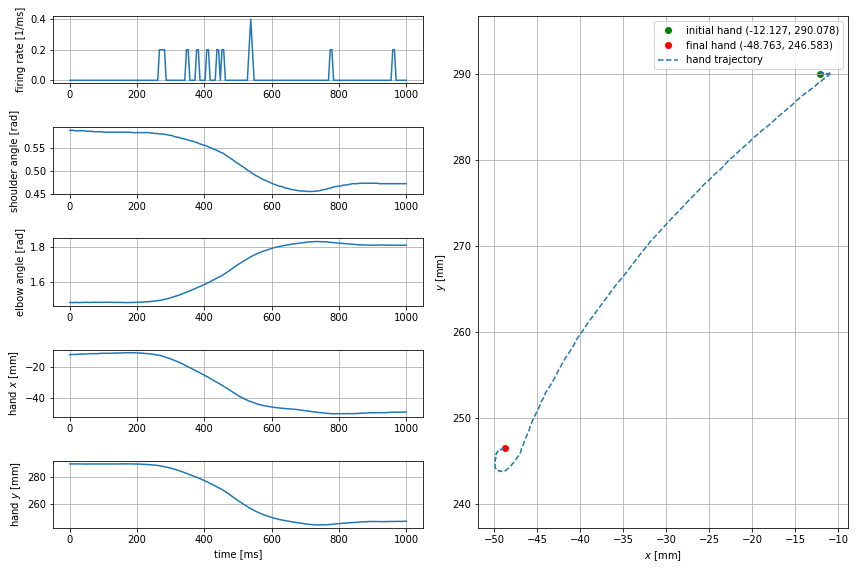

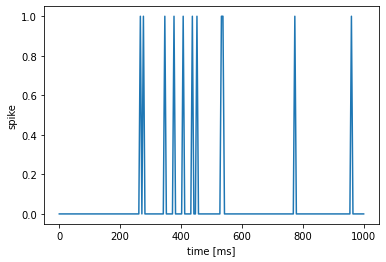

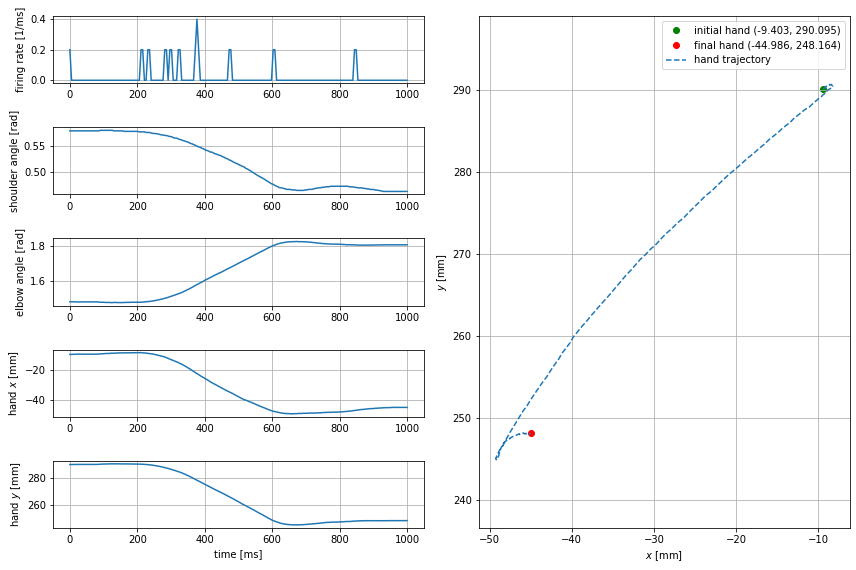

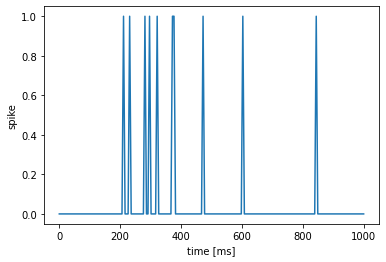

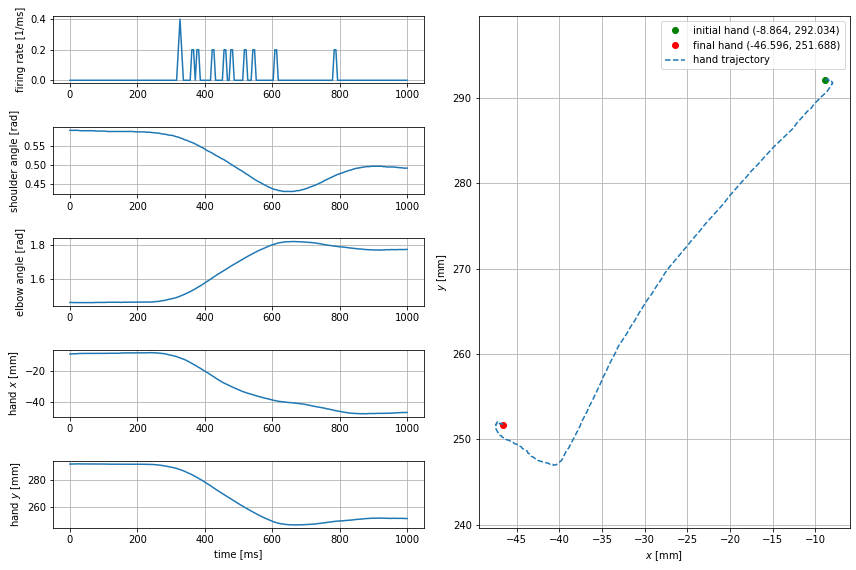

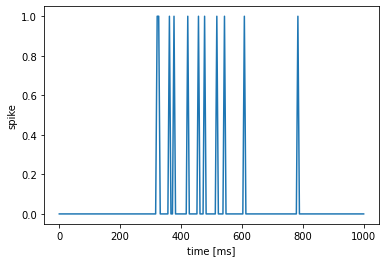

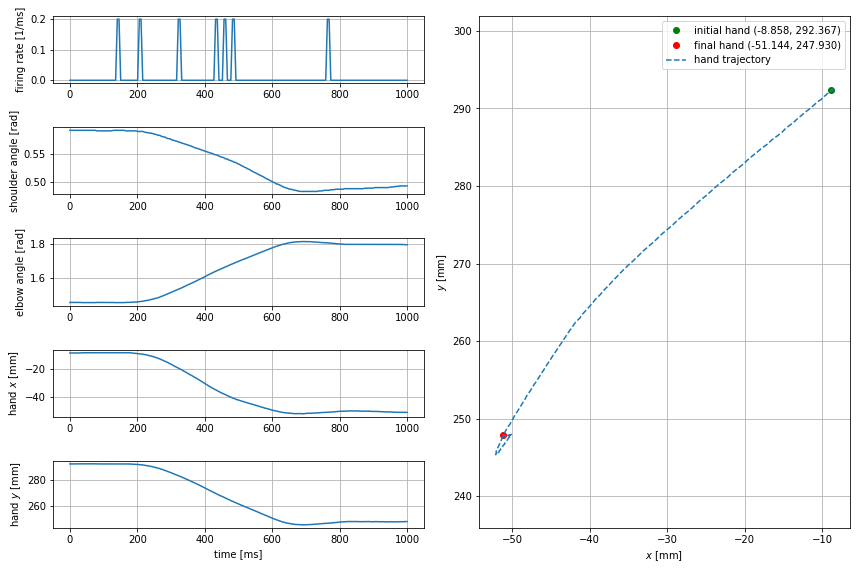

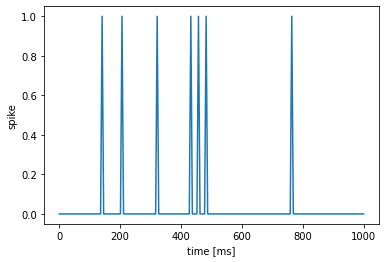

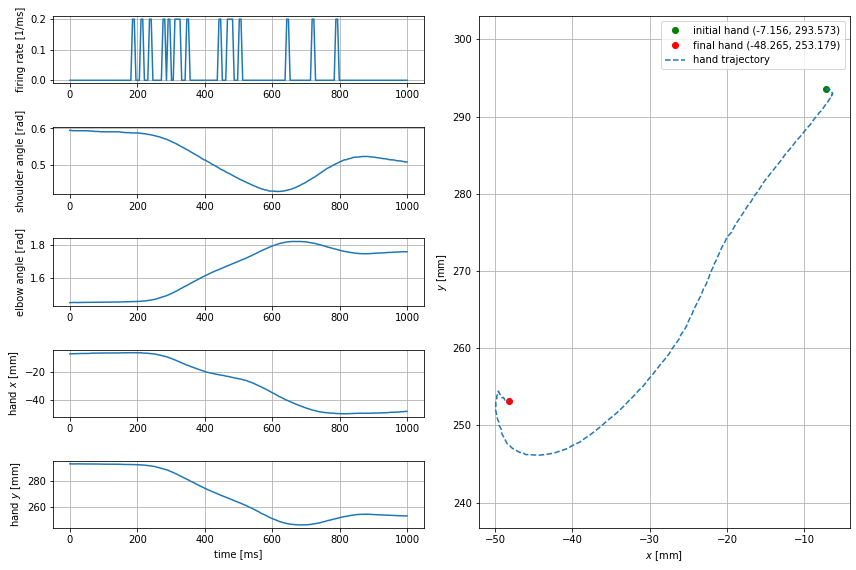

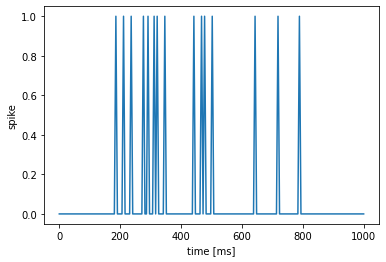

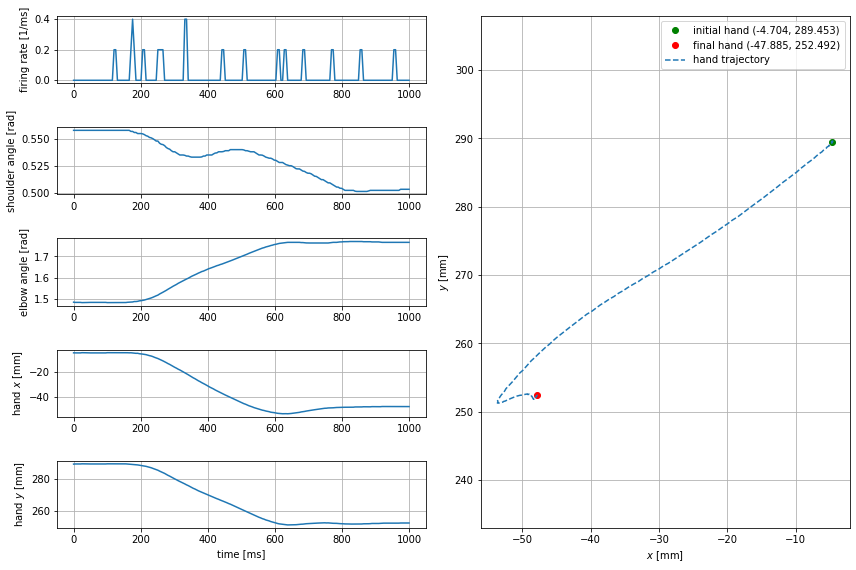

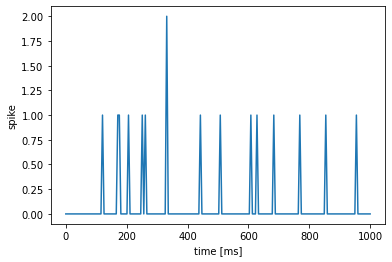

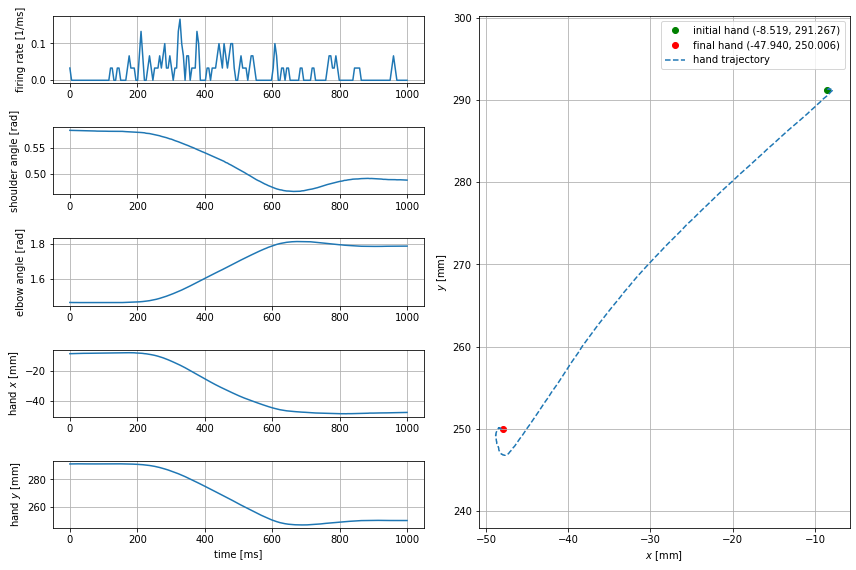

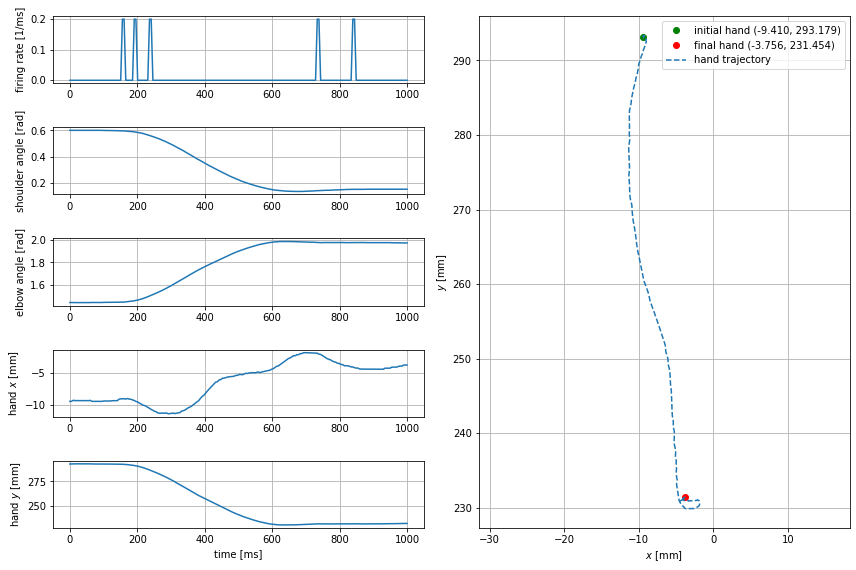

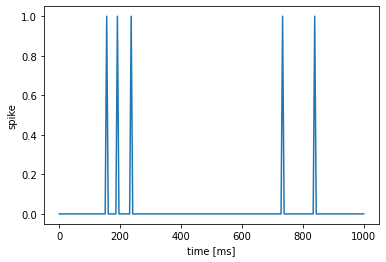

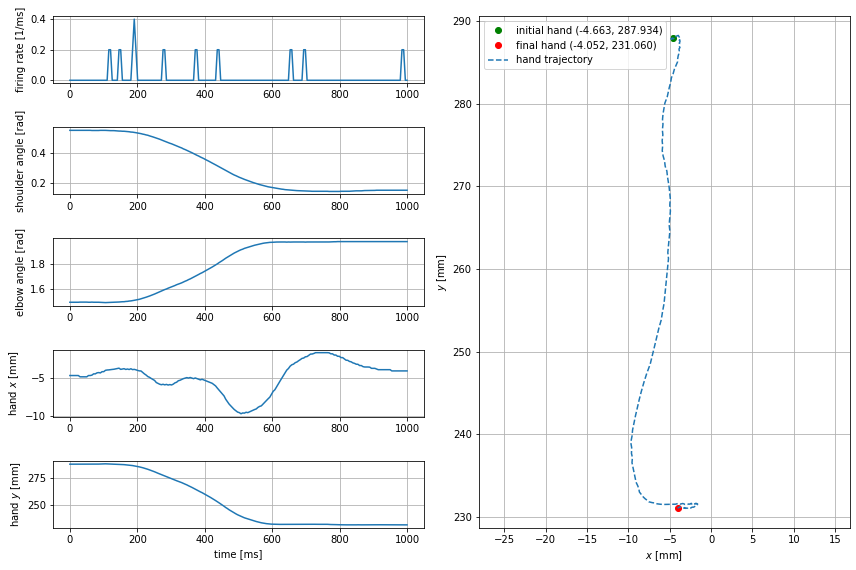

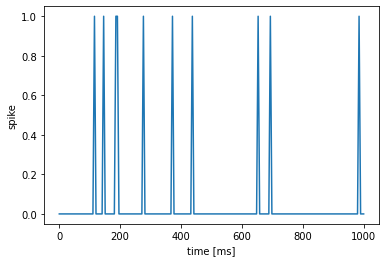

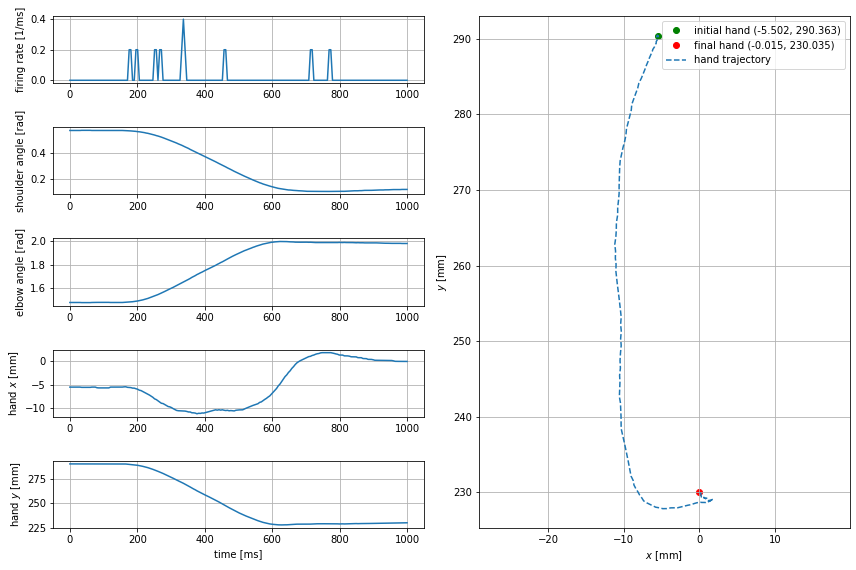

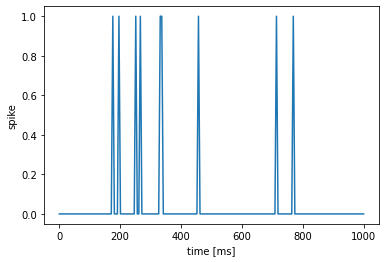

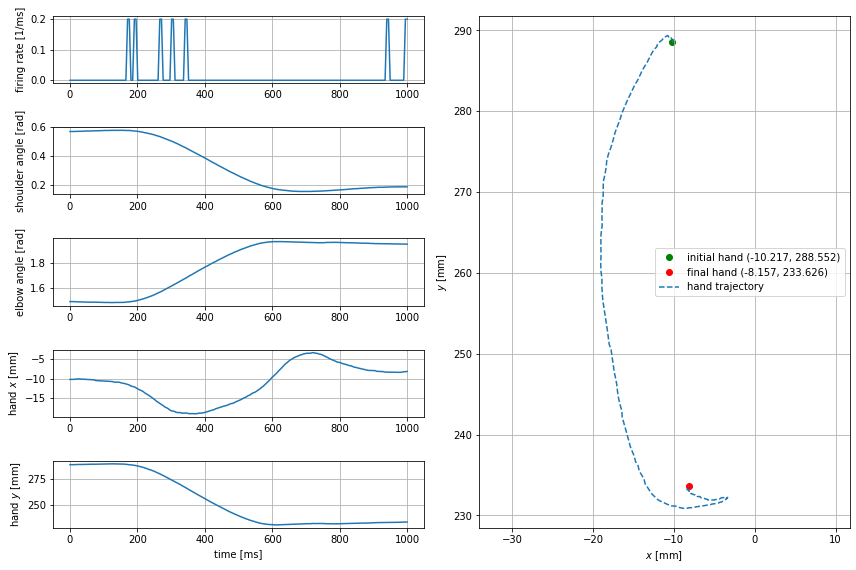

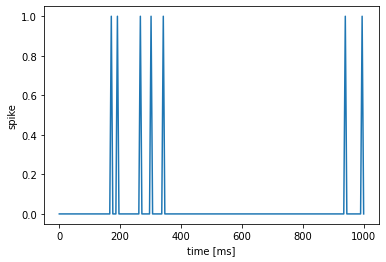

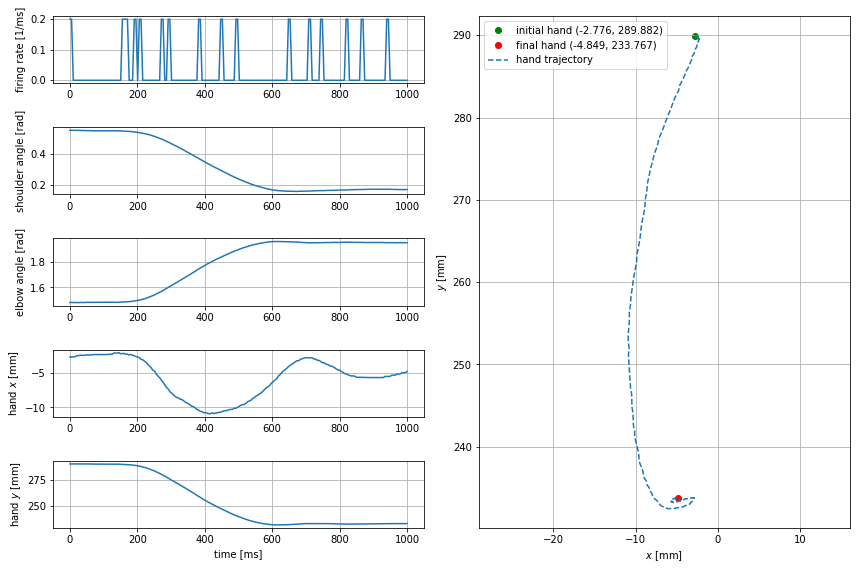

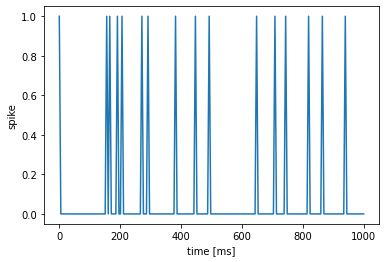

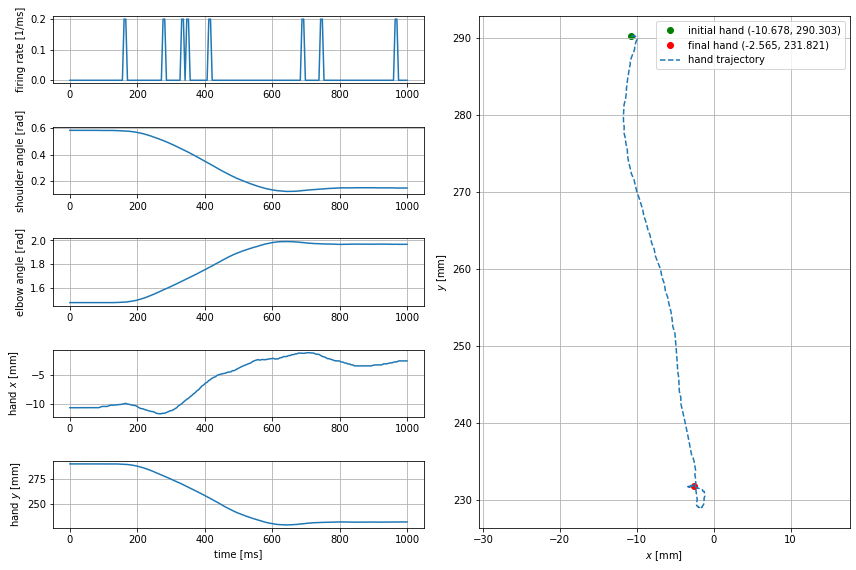

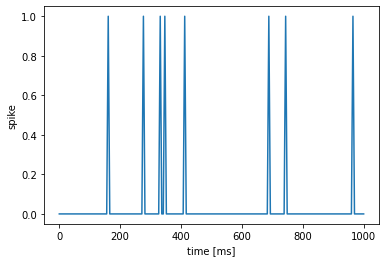

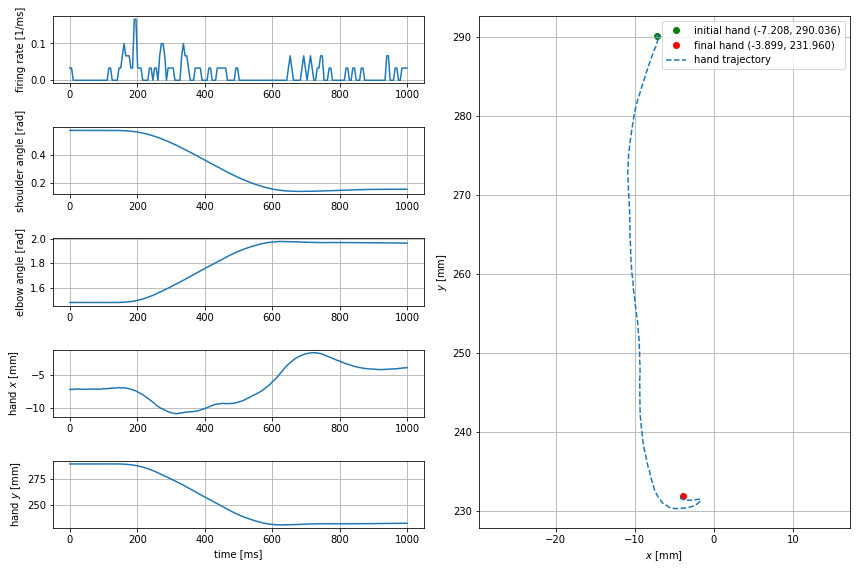

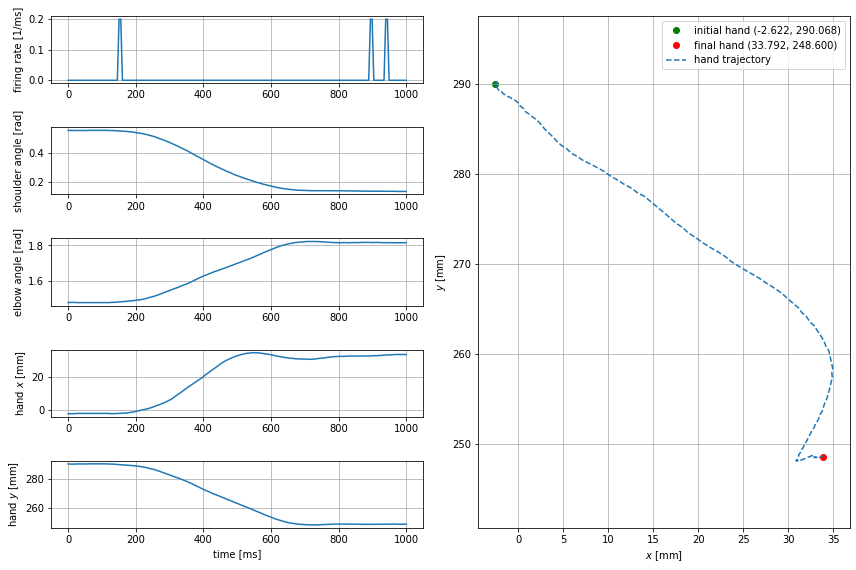

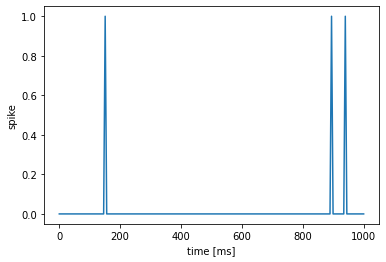

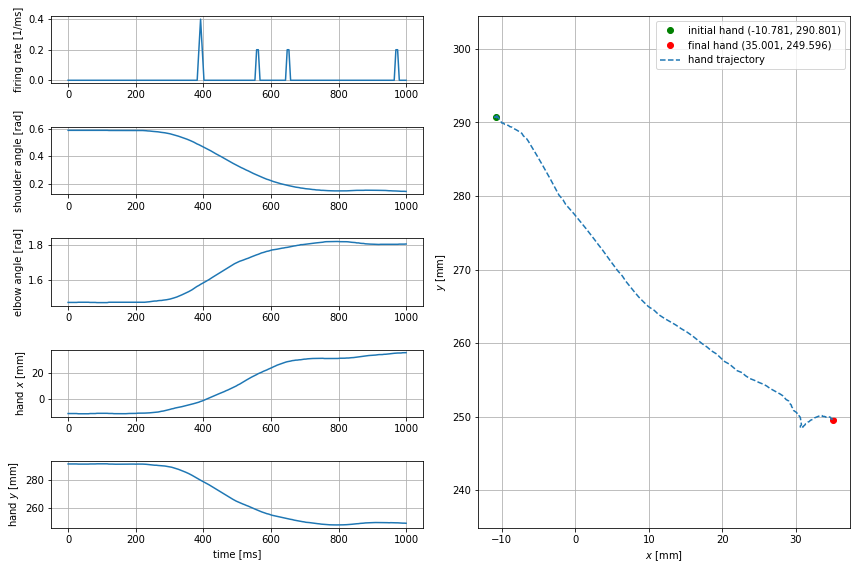

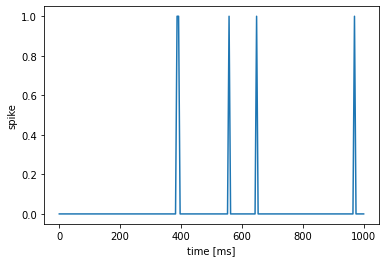

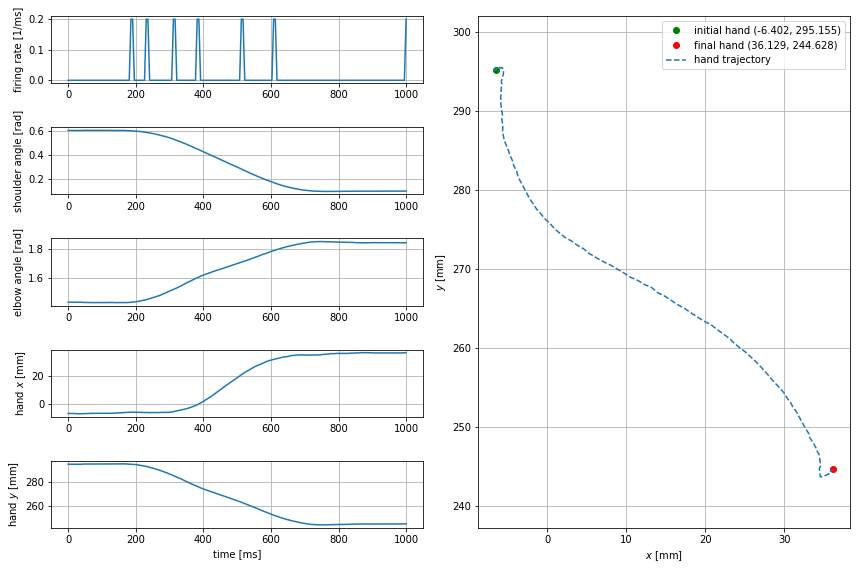

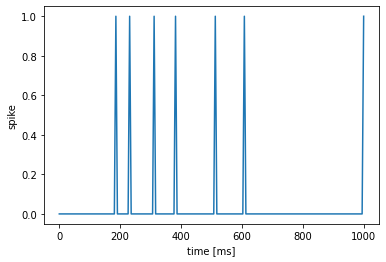

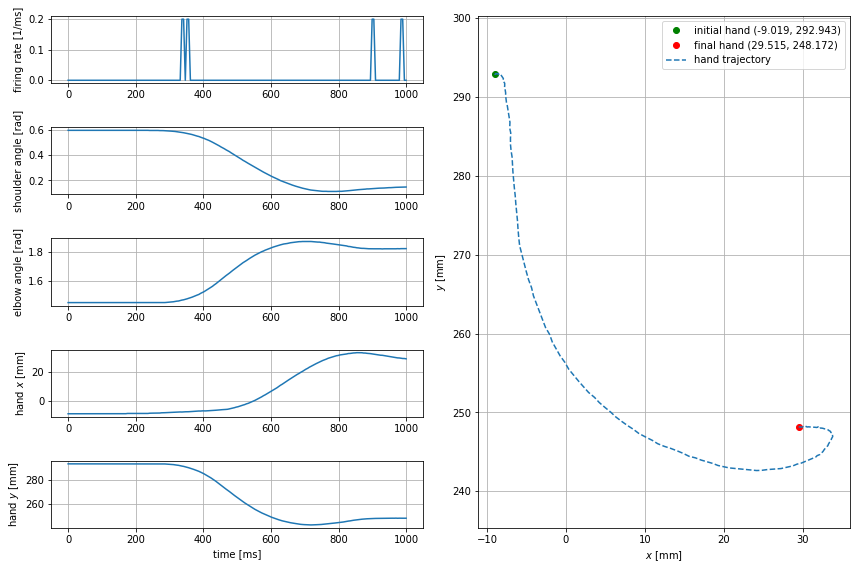

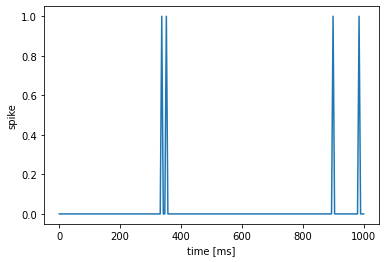

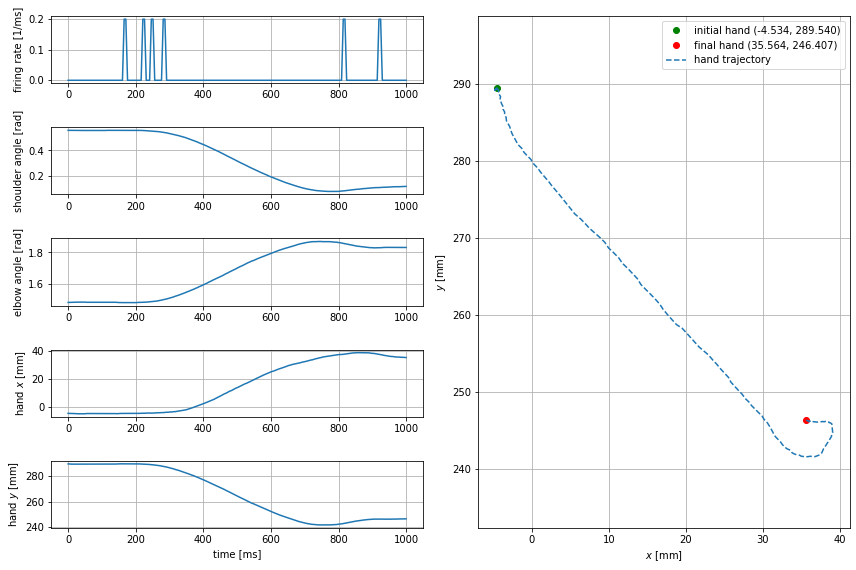

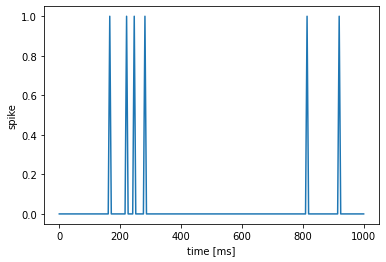

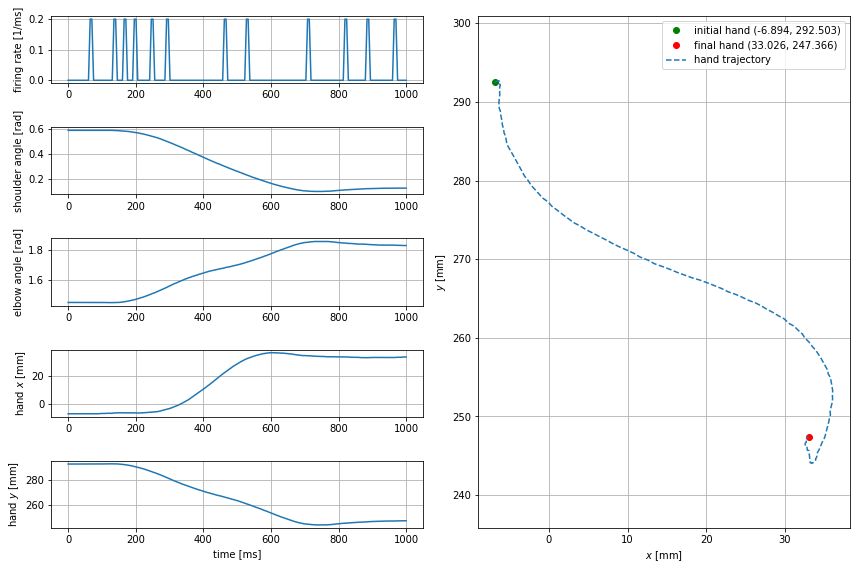

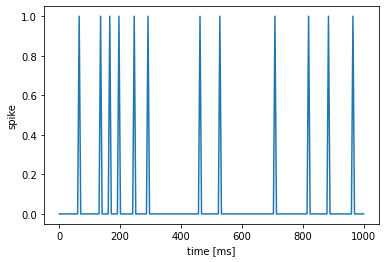

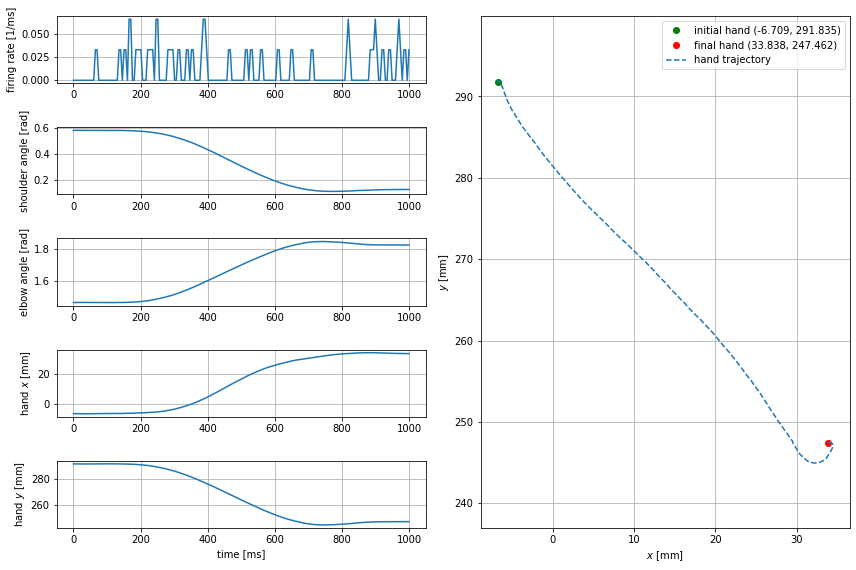

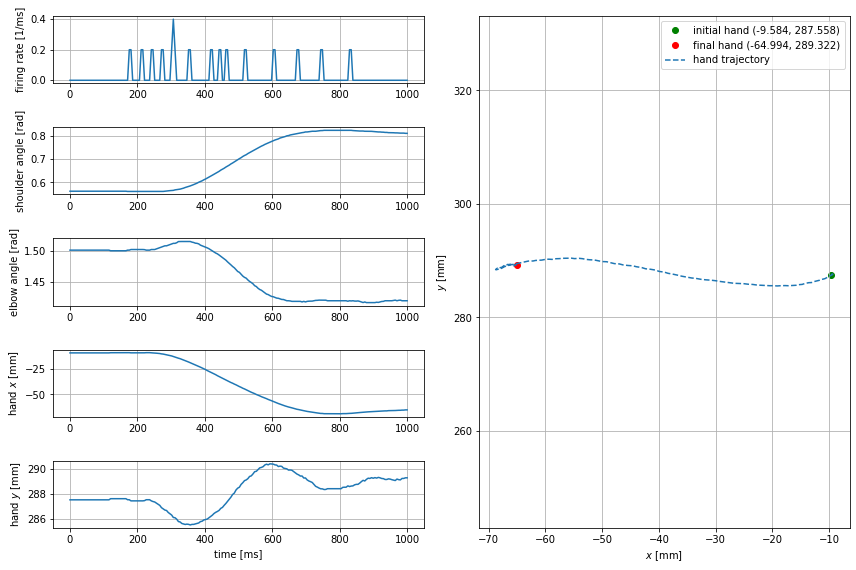

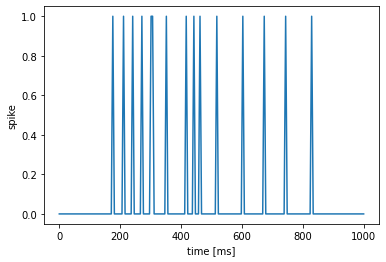

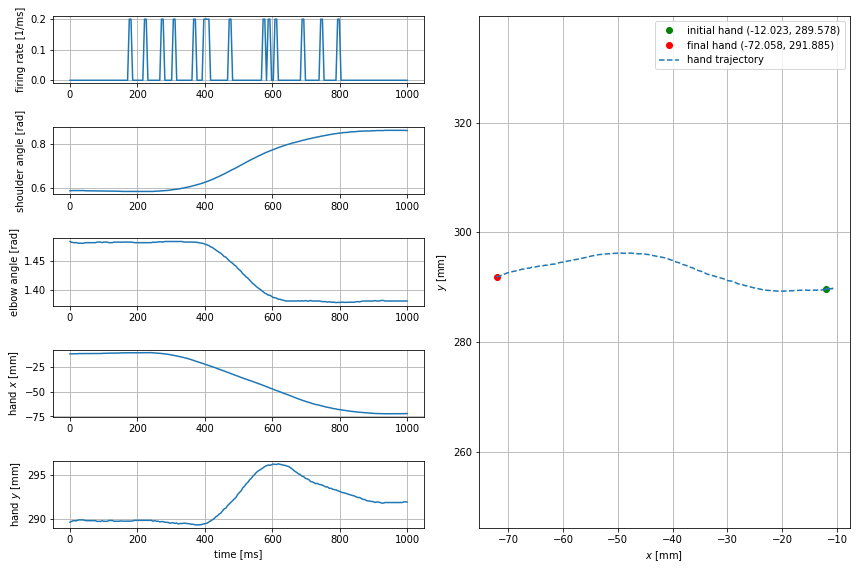

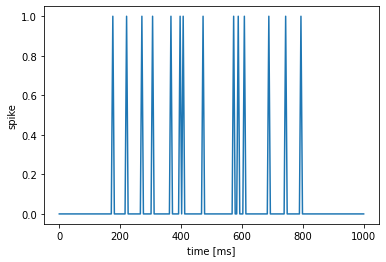

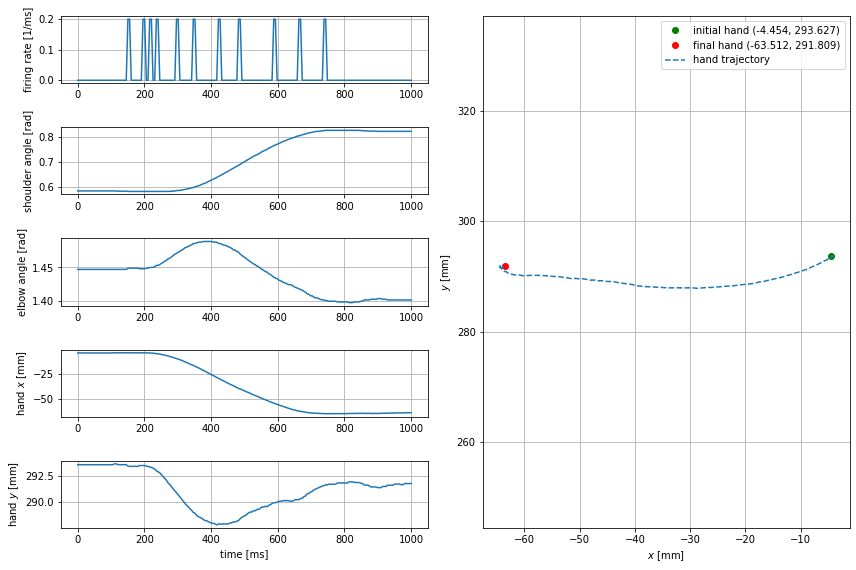

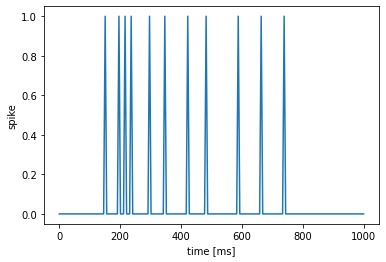

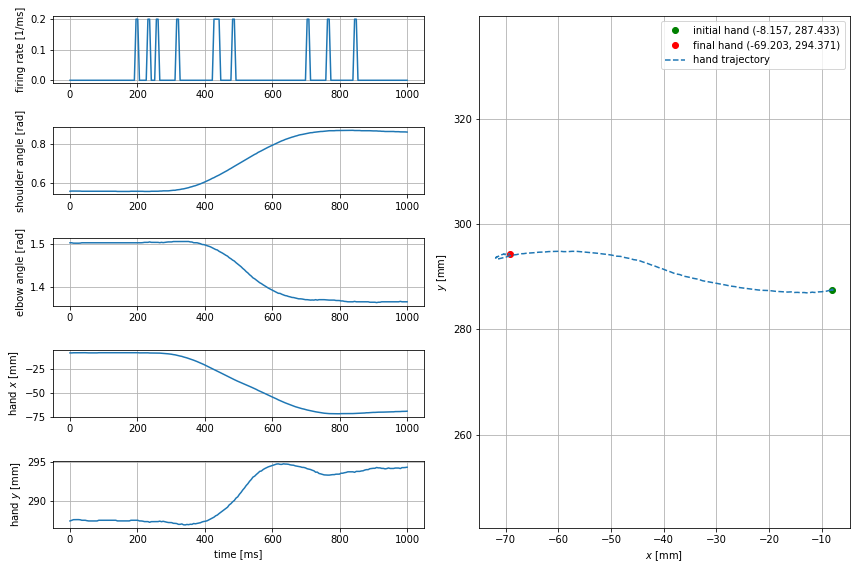

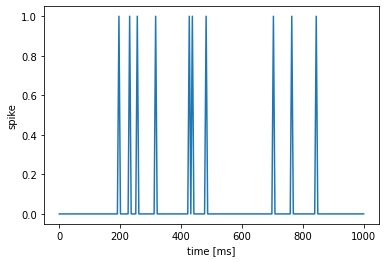

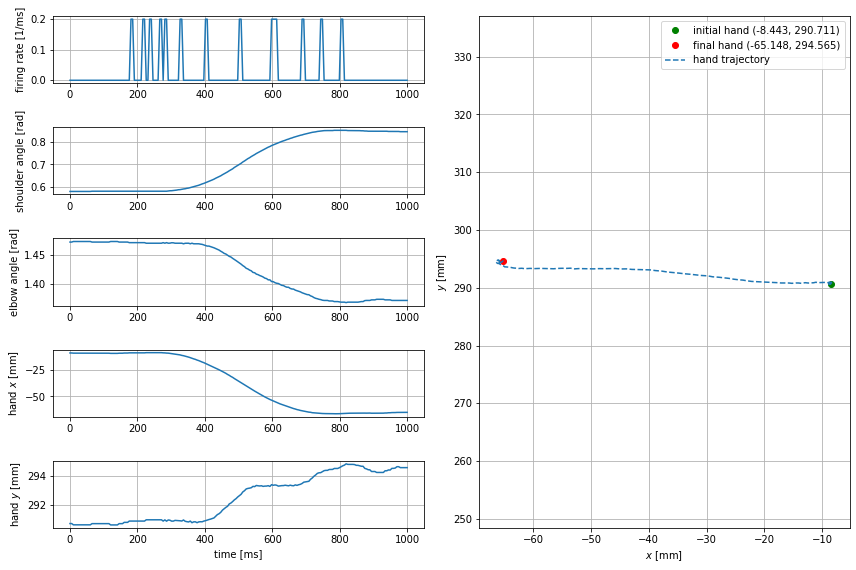

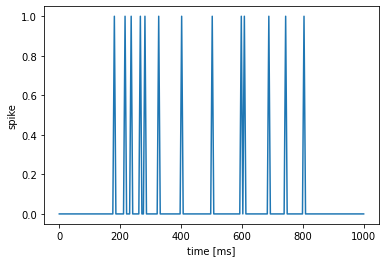

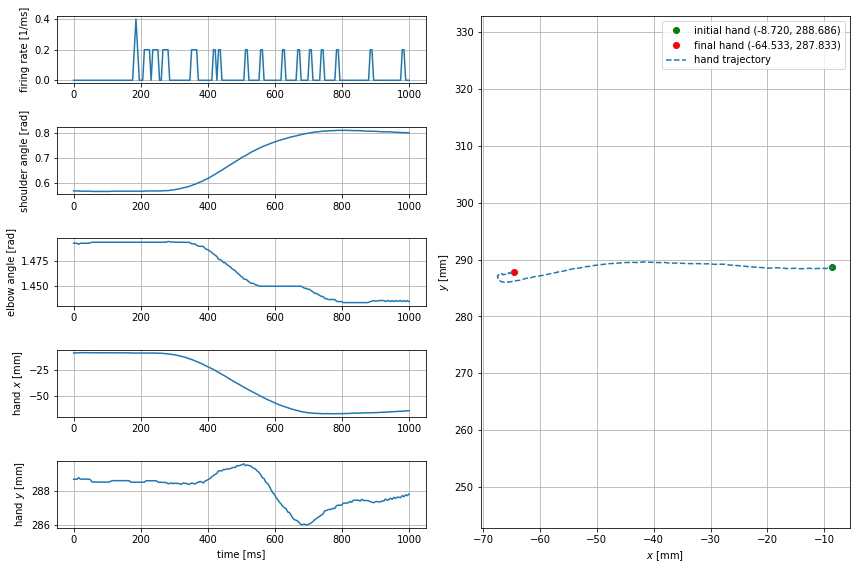

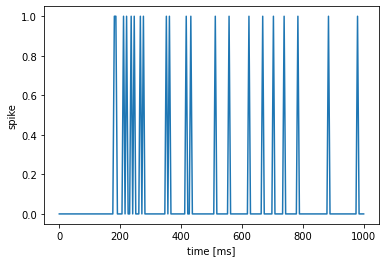

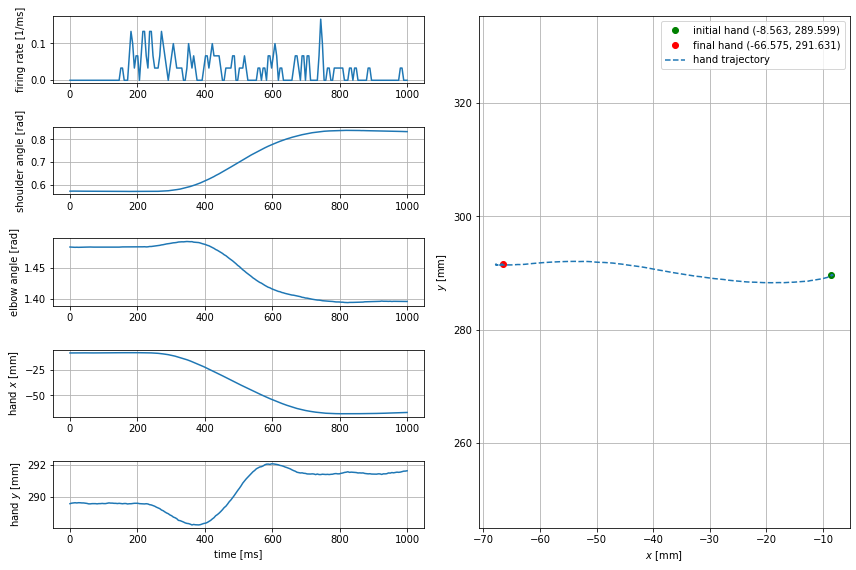

In [61]:
plot_experiments()

### Plot the mean spike count w.r.t. the target's position to show the cell's preferred direction
Explore the relationship between the firing rate (~ spike count) and the movement kinematics.

Compute the mean initial position of the hand over the targets. \
Compute the target's position with the highest spike count. \
Compute the origin of the vector of the cell's preferred direction. \
Make sure that the end of the vector touches the target with the highest spike count.

In [73]:
# Mean initial hand position over the targets
mean_initial_handxpos = sum(initial_hands_x)/8
mean_initial_handypos = sum(initial_hands_y)/8

# Find the target with the highest spike count
max_index = list(spike_counts).index(max(spike_counts))
print(f"Target with highest mean spike count: target {max_index+1} at (x ~ {targets_x[max_index]:.3f}, y ~ {targets_y[max_index]:.3f})")
max_x, max_y = targets_x[max_index], targets_y[max_index]

# Vector origin = Center of the circle formed by the targets = Mean initial hand position
vector_origin = (mean_initial_handxpos, mean_initial_handypos)

# Normalize the vector to terminate at the target point
dx = max_x - vector_origin[0]
dy = max_y - vector_origin[1]

Target with highest mean spike count: target 3 at (x ~ -3.207, y ~ 347.668)


Show the direction that evokes the highest activity, the cell's preferred direction. \
3D plot: (target x, target y) -> spike count

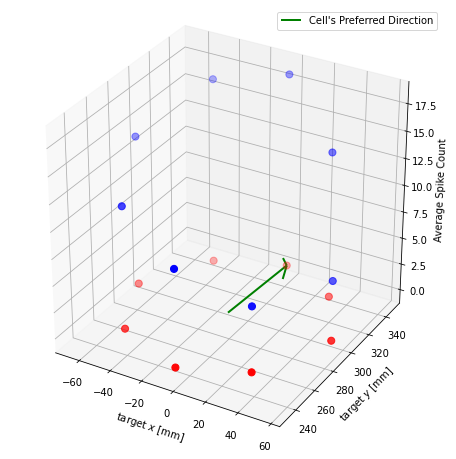

In [78]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the target positions as red points (z=0)
ax.scatter(targets_x, targets_y, [0]*len(targets_x), color='red', s=50)

# Plot the spike counts as blue points 
ax.scatter(targets_x, targets_y, spike_counts, color='blue', s=50)

# Draw the vector in the Oxy plane (z=0) towards the target with the highest spike count
ax.quiver(
    vector_origin[0], vector_origin[1], 0,  # Vector start point (x, y, z)
    dx, dy, 0,  # Vector components (dx, dy, dz)
    color='green', label="Cell's Preferred Direction", arrow_length_ratio=0.07, linewidth=2
)

# Ensure equal scaling for x and y axes
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes

# Labels
ax.set_xlabel("target $x$ [mm]")
ax.set_ylabel("target $y$ [mm]")
ax.set_zlabel("Average Spike Count")
ax.tick_params(axis='both', labelsize=10)  # Adjust tick size to reduce clutter
ax.legend()

# plt.savefig("plots/mean_spike_counts.pdf")

plt.show()

In [70]:
list(spike_counts)

[5.666666666666667,
 13.666666666666666,
 18.166666666666668,
 17.333333333333332,
 11.5,
 9.166666666666666,
 6.166666666666667,
 14.0]

### Plot the mean initial and final hand positions

The mean final hand positions are approximations of the positions of the 8 targets. \
The 8 targets form a circle.

In [64]:
# Initial hands and Targets in [mm] 
print("[mm]               x        y                        x              y")
for i in range(8):
    print(f"initial hand {i+1}: {initial_hands_x[i]:.3f} \t {initial_hands_y[i]:.3f} \t target {i+1}: {targets_x[i]:.3f} \t {targets_y[i]:.3f}")

print("\n")

# Initial hands and Targets in [m] to use for simulations with code of Project 1
converted_initial_hands_x = 1e-3 * initial_hands_x
converted_initial_hands_y = 1e-3 * initial_hands_y
converted_targets_x = 1e-3 * targets_x
converted_targets_y = 1e-3 * targets_y
print("[m]                 x               y                         x             y")
for i in range(8):
    print(f"initial hand {i+1}: {converted_initial_hands_x[i]:.4f} \t {converted_initial_hands_y[i]:.4f} \t target {i+1}: {converted_targets_x[i]:.4f} \t {converted_targets_y[i]:.4f}")

# To use for simulations with code of Project 1
print("\n")
print("initial hands x [m]:", list(converted_initial_hands_x))
print("initial hands y [m]:", list(converted_initial_hands_y))
print("targets x [m]:", list(converted_targets_x))
print("targets y [m]:", list(converted_targets_y))

[mm]               x        y                        x              y
initial hand 1: -5.624 	 289.084 	 target 1: 56.252 	 293.441
initial hand 2: -6.338 	 289.824 	 target 2: 33.757 	 330.799
initial hand 3: -7.280 	 290.584 	 target 3: -3.207 	 347.668
initial hand 4: -6.336 	 289.893 	 target 4: -42.400 	 332.194
initial hand 5: -8.519 	 291.267 	 target 5: -47.940 	 250.006
initial hand 6: -7.208 	 290.036 	 target 6: -3.899 	 231.960
initial hand 7: -6.709 	 291.835 	 target 7: 33.838 	 247.462
initial hand 8: -8.563 	 289.599 	 target 8: -66.575 	 291.631


[m]                 x               y                         x             y
initial hand 1: -0.0056 	 0.2891 	 target 1: 0.0563 	 0.2934
initial hand 2: -0.0063 	 0.2898 	 target 2: 0.0338 	 0.3308
initial hand 3: -0.0073 	 0.2906 	 target 3: -0.0032 	 0.3477
initial hand 4: -0.0063 	 0.2899 	 target 4: -0.0424 	 0.3322
initial hand 5: -0.0085 	 0.2913 	 target 5: -0.0479 	 0.2500
initial hand 6: -0.0072 	 0.2900 	 target 6

In [65]:
def plot_hands():
	"""
	Plot the 8 mean initial and final hand positions and mean hand trajectories.
	"""
	fig = plt.figure(figsize = (8, 6))
	for i in range(8):
		plt.scatter(initial_hands_x[i], initial_hands_y[i], c = colors[i], label = f"exp {i+1}")
		plt.scatter(targets_x[i], targets_y[i], marker = "*", c = colors[i], s=150)
		plt.plot(handxposs[i], handyposs[i], c = colors[i])
	plt.xlabel("$x$ [mm]") ; plt.ylabel("$y$ [mm]")
	plt.axis('equal')
	plt.legend()
	plt.grid()
	# plt.savefig(f"plots/mean_initial&final_hand_positions_mean_hand_trajectories.pdf")
	plt.show()

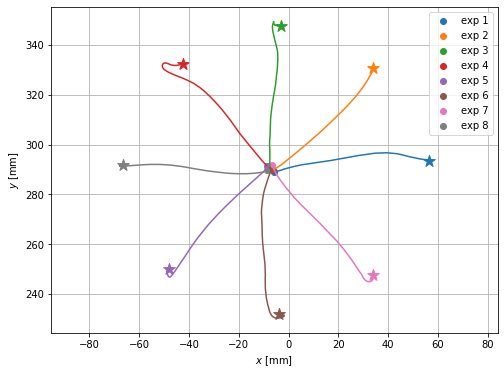

In [66]:
plot_hands()

## Bonus

We already have the mean monkey's hand trajectories towards the 8 targets. \
Use the mean initial monkey's hand positions as the initial conditions and the mean final monkey's hand positions as the 8 targets for the SOC. \
Compare the hand trajectories of the monkey and the SOC towards the 8 targets.

The hand trajectories of the SOC computed with the code of Project 1 for the same initial conditions and targets as in this Project 2.

In [39]:
# Hand trajectories of the SOC for each target
SOC_x = np.array([[-5.624166666666652, -5.257743086531763, -5.023743922065671, -5.116949552578964, -5.018880429992323, -5.151855413946582, -5.556743745303017, -5.2832997839621925, -5.230073868778495, -5.446861205583908, -5.400643390912229, -5.252693937315089, -5.045029653803157, -4.847240066777836, -4.933429455942884, -4.99799451072197, -4.865436865983897, -4.744069728420508, -4.746165758487297, -4.70027897870573, -4.470303114572916, -4.3340387466745955, -4.247512736794857, -4.177342768824865, -3.9976312256642665, -3.937154259088138, -3.790284899876206, -3.5830903757679833, -3.279063417875261, -3.118764232680593, -2.924684053851323, -2.7601828031098563, -2.5195688710978326, -2.3109736273072556, -2.108252235673458, -1.8103072695618838, -1.546056585457034, -1.2085728176079447, -0.9369913655257744, -0.713962780520494, -0.4524003169990021, -0.13626528663240878, 0.1240151666666578, 0.4446795610801302, 0.7473435708195142, 1.0776397162522433, 1.4156175075869526, 1.7667730893202171, 2.1037801551559987, 2.504836885708961, 2.866559387476375, 3.2446993869290064, 3.5859802911645255, 3.952696484563978, 4.351708864435921, 4.742854223606486, 5.140202563542696, 5.515594453820327, 5.879325235274013, 6.269012848794054, 6.7063097224023815, 7.157957589498332, 7.575966586701732, 8.022276528436123, 8.469373126663571, 8.896298600591823, 9.34432132382823, 9.78129745329892, 10.238036026700925, 10.6623031637344, 11.125549855990846, 11.541918664777274, 12.026074545644915, 12.484966494193618, 12.93734464684726, 13.400031484779307, 13.860308462921688, 14.301797896423718, 14.751455219456089, 15.204463684162729, 15.655567775842982, 16.131773337603516, 16.650078662889143, 17.134466896617127, 17.6412742736311, 18.121240385434724, 18.6272427169375, 19.13478190490514, 19.632891838904044, 20.13213244535178, 20.626742245883843, 21.131583164380185, 21.629234806853802, 22.163570726604075, 22.711771464318907, 23.25962252238678, 23.773790381380167, 24.28386225890311, 24.834377773627846, 25.369141580865286, 25.946700012405564, 26.484010540696545, 27.046557636271285, 27.62093979882707, 28.172561199717116, 28.742687192963746, 29.33344270663313, 29.87044414450113, 30.414965796253913, 30.94675459934171, 31.490444545922813, 32.01176833201719, 32.5375042380458, 33.04573192883953, 33.55667321174999, 34.074980287030435, 34.57587718914007, 35.094925663964105, 35.58051427513858, 36.080122540279426, 36.5968457967536, 37.08533739425296, 37.55171098989213, 38.03146750232506, 38.49893917855268, 38.97169778363718, 39.45041121508544, 39.88789099626017, 40.334983017203314, 40.78582940505898, 41.21119626751554, 41.62143870850352, 42.04049092118814, 42.433715057009714, 42.827724601876284, 43.174021218090914, 43.54435080832159, 43.91861648457515, 44.268654904216, 44.61742346224154, 45.00327027523099, 45.3532498463369, 45.69475660112024, 46.0679392543667, 46.41627458634937, 46.768564776949155, 47.11135313767883, 47.448097319582274, 47.78763677640072, 48.11572562279912, 48.45795682345305, 48.77032428406891, 49.08472679068607, 49.394128630821186, 49.68380656118968, 49.969827123761775, 50.26177661494527, 50.52216662015746, 50.808806744618074, 51.10826877416289, 51.39884679944293, 51.692718333835735, 51.97906060210758, 52.25411643250055, 52.525618948208255, 52.8039953568612, 53.0693471611916, 53.32611877406887, 53.5759908245626, 53.821101640548456, 54.02914684826177, 54.22863832505839, 54.43276139292907, 54.62664403160797, 54.8255977871801, 54.99820978028169, 55.16112001241938, 55.29321404759705, 55.43710236879107, 55.55573183441917, 55.668640919362325, 55.75988695845802, 55.87121945567938, 55.96365643704537, 56.04162965926396, 56.103049524218655, 56.143414030362855, 56.16004321188991, 56.1553460280648, 56.180993760892555, 56.18865362169037, 56.1915380710902, 56.201806885168544, 56.19858171511311, 56.20511189301627, 56.21291881459009, 56.23548281082758, 56.23479064666259, 56.23935736798516, 56.23525010735911], [-6.338100000000013, -5.842990205967846, -7.0697208123616795, -6.7440775805601145, -6.503877320130358, -6.419318288915399, -6.379760321452322, -6.381894342360028, -6.381948405973281, -6.160417503295379, -6.133042247415343, -5.980853588633872, -6.003284968705113, -5.933930018810097, -6.033928129638822, -5.972870596884727, -5.828010241725523, -5.833312896209531, -5.727454178195702, -5.678273150769575, -5.720601262724834, -5.68452193974911, -5.716348997769294, -5.565881737353228, -5.498979507394141, -5.433661074793649, -5.308566806944414, -5.100016301680721, -4.990983580305475, -4.9148632699898, -4.885236577192032, -4.788257179621336, -4.594482829459013, -4.439457891768472, -4.358296135541284, -4.17882583903062, -4.043054336818952, -3.8950583304823705, -3.731589894004461, -3.5979924891677006, -3.4187287349989326, -3.2424779156992045, -3.0959503739478866, -2.9348580637859056, -2.6973543570272263, -2.5370542089566683, -2.3703072572555106, -2.209062580083798, -2.04903046938687, -1.8981425983580769, -1.7490842587945532, -1.5791046599771263, -1.4448262118257893, -1.245930621496083, -1.0642496427277215, -0.8909154653444773, -0.7348738122849863, -0.5346974881544342, -0.3782456370275966, -0.20169269091191433, -0.022864289848323338, 0.19879673893380412, 0.4417361043604351, 0.6566912267630953, 0.880458730939726, 1.0768902262995317, 1.2817221806318835, 1.5032062159567317, 1.7374371270681976, 1.9733490420698052, 2.201045652797662, 2.4488084762544493, 2.7209671354110343, 2.988777789296737, 3.256347382219582, 3.517777761212315, 3.7902078418983742, 4.058713543872827, 4.3515214641799975, 4.64934562389746, 4.961786643041311, 5.270546045159086, 5.539299557950905, 5.834971567119929, 6.1386062597986735, 6.448293825223772, 6.747561976553518, 7.061307115120597, 7.359189118145482, 7.651310788054588, 7.93324282061636, 8.208993859655955, 8.480981873711102, 8.748072797415407, 9.02276376115535, 9.29289120981014, 9.583404750913738, 9.848223702319137, 10.126898734495516, 10.426081598423952, 10.686929702950486, 10.948804213355313, 11.21560451917125, 11.487602094641392, 11.783758364419416, 12.049561880870085, 12.319280797604915, 12.600480284330583, 12.889653216802465, 13.162328948571556, 13.431987100276654, 13.675021738098037, 13.959638259883445, 14.219880153278408, 14.499673723265383, 14.799227482716336, 15.120859807530639, 15.432840067134412, 15.762770486759504, 16.091208002880997, 16.431895586073942, 16.775240920479607, 17.151933882582014, 17.546429586112023, 17.943580928669988, 18.352072987470713, 18.729507972377103, 19.110425452524225, 19.510412924160836, 19.881808827999002, 20.23221326720043, 20.59808590388418, 20.95483341201321, 21.32123218817067, 21.670269126247256, 22.006959317140364, 22.341004867550474, 22.673568282093935, 22.989731715858607, 23.30535344780199, 23.644094107596437, 23.971363465045027, 24.285483034436005, 24.59601903559, 24.914003284659536, 25.216462150126183, 25.51737568396423, 25.818538805187142, 26.09575783517898, 26.34781186862323, 26.600234276945745, 26.837308336432606, 27.06659589911986, 27.29408499937891, 27.50764305417347, 27.725801048516463, 27.938407471952697, 28.13709316501667, 28.34898074291997, 28.55603439800891, 28.76966922518448, 28.985338444626695, 29.191393789447602, 29.40161110995243, 29.606369026139916, 29.82684857456122, 30.03393748306943, 30.23267115498207, 30.447850362303242, 30.66608312093311, 30.87944708081919, 31.07783793188601, 31.276807690639174, 31.462008445764717, 31.637773660004004, 31.824758924831915, 32.00253518115212, 32.161991389627524, 32.30656265758919, 32.4532503349656, 32.597990552898054, 32.725069331466486, 32.8467884666091, 32.9580639005137, 33.03902118648316, 33.1258119047469, 33.18912306063096, 33.2335287124807, 33.283922625424125, 33.32448858826381, 33.37073711511121, 33.413463928694654, 33.43806998546883, 33.483098554573736, 33.51113624455995, 33.52117848777017, 33.53968030820342, 33.550701504563655, 33.55700232461559, 33.55461072384511], [-7.280333333333278, -7.290028249950065, -7.274886694116467, -7.454065300172951, -7.4861163092940775, -7.421185391899121, -7.53880501715487, -7.466377583556949, -7.405506052122535, -7.330692457020671, -7.382906685550362, -7.45373351011186, -7.297210863625391, -7.2901529227956114, -7.2693121469304405, -7.257279198301991, -7.290160831257941, -7.290181583017031, -7.368127433215966, -7.288755762703492, -7.447741333522329, -7.3771993681678305, -7.302028752368184, -7.215596041304395, -7.213021998124846, -7.221861154118825, -7.2411638360531105, -7.216207852932365, -7.257593925380334, -7.298974456365737, -7.2533365606425315, -7.182173925609103, -7.171853540002216, -7.122362943332183, -7.149537067656753, -7.225678686893833, -7.156464852063948, -7.115743845784561, -7.052649498855423, -7.00026378831986, -7.024080620678053, -7.011153134846793, -6.961075637670067, -6.923280714278501, -6.849150654636871, -6.8360107649041435, -6.862007629263589, -6.804294644150389, -6.791691715124449, -6.754951302854195, -6.735647994143279, -6.7298067716999865, -6.683822901191904, -6.655045945407167, -6.567037665533515, -6.501703192755059, -6.462955240461921, -6.449011076541444, -6.367924789454193, -6.299079411350606, -6.228040657785927, -6.193887612589211, -6.1957412709722774, -6.167852095456173, -6.134402260074612, -6.10430966276998, -6.057657342722067, -6.0149538496947486, -5.986197807178851, -5.9433530149214375, -5.908546846365437, -5.863380875119617, -5.853895851582191, -5.809198264545734, -5.738381586749219, -5.689687407954502, -5.640459526259079, -5.564777798033882, -5.514542570785707, -5.471630985988463, -5.428881667604246, -5.386266435403075, -5.326747778846174, -5.277148280367072, -5.22045431608259, -5.19705012155991, -5.1428255783319, -5.104600403335269, -5.049220176441271, -4.989248370938116, -4.920370755842118, -4.861177542920759, -4.816072894976598, -4.792954787728454, -4.750064438333923, -4.7072345296442215, -4.668247029793515, -4.62680036406915, -4.600158688944756, -4.567980483051571, -4.535280479521841, -4.529427908746831, -4.519462063562685, -4.515788829378531, -4.538646765968379, -4.545713767259707, -4.5901356242235565, -4.608172499787344, -4.639951228516848, -4.65785024384302, -4.718202200359956, -4.736407941191012, -4.756718214697086, -4.769779558555676, -4.784585887946225, -4.793077357651054, -4.820841705643508, -4.847917986250505, -4.844989006321187, -4.8774960428373815, -4.887533363864216, -4.92139971538319, -4.943847506424904, -4.964851471210007, -4.990904675349239, -5.018873420921555, -5.038286868581765, -5.058450154594274, -5.112588964911402, -5.154734917452053, -5.1768296944207925, -5.211073739804228, -5.265455523674634, -5.287097473260616, -5.3374193971922885, -5.36289851757582, -5.3865318137649165, -5.419685233366833, -5.450265460211434, -5.461694434358622, -5.4725647023495245, -5.493304132673627, -5.504061099956492, -5.551582461907456, -5.587398900039453, -5.601287436087842, -5.629236108021574, -5.668352752512207, -5.711448500154315, -5.7514960972602776, -5.798385634252112, -5.838168356881668, -5.8791489317464585, -5.907511855005487, -5.936707463102875, -5.955661260191203, -5.960565608581215, -5.95184900613166, -5.933269216576498, -5.916148975054769, -5.910110111190303, -5.893679542435359, -5.845585424687439, -5.792152066155687, -5.737346847684122, -5.664775399949695, -5.613991921043116, -5.548344192014055, -5.450566031872217, -5.3571012136443, -5.250139413825128, -5.141068330011766, -5.043639643640352, -4.952078634319235, -4.856146856478006, -4.739575357282144, -4.608487181584131, -4.496335153825026, -4.3658926007068, -4.253540907018127, -4.129061833557657, -4.0410531084209005, -3.936777717635842, -3.8307084766551203, -3.7374821803104474, -3.6530574353522693, -3.5587731112881604, -3.4575873205256458, -3.374217235863619, -3.297918264856592, -3.233949358834809, -3.1639708398811806, -3.098491053490582, -3.0475440278914245, -2.9888442896581213, -2.9594597621134255, -2.938758726829971, -2.9228427242732336, -2.9408568763291676, -2.931875430806141], [-6.336333333333332, -6.305058026756905, -6.14473152572187, -5.377765403837886, -5.730986444038466, -5.772253483333712, -5.859212375108114, -6.094999699059245, -6.075947160996408, -6.320501735483653, -6.278717271632594, -6.290418338330383, -6.252957640701995, -6.346341245751508, -6.377245535114318, -6.4636813003545175, -6.473113392366503, -6.519207957439654, -6.50914546894793, -6.644500891954397, -6.610285545015804, -6.721780142892097, -6.8329410071449885, -6.873259625826245, -7.034874428959059, -7.076586884824043, -7.170371525568264, -7.2423080030952764, -7.383104961562026, -7.416815135618037, -7.505764360764722, -7.566030965401149, -7.618086326847573, -7.765916295540521, -7.886896074763339, -7.9889852304054205, -8.116045519354131, -8.21333421962639, -8.35990745574955, -8.482676198747264, -8.63315772471246, -8.772877371668708, -8.919456489160481, -9.099570900020948, -9.245855193380004, -9.418251739956919, -9.579443469768245, -9.769762087444677, -9.90101327902082, -10.088897393965734, -10.267191415653299, -10.4447728887348, -10.660024662423051, -10.86604582057843, -11.088954736739264, -11.250131182667488, -11.477782342987354, -11.72820966889293, -11.963161262504574, -12.156414418659, -12.401492266981617, -12.614880616232949, -12.857311962981788, -13.132023944167571, -13.411468061334308, -13.64939532863435, -13.892842522548909, -14.176077847054158, -14.45627732523419, -14.691161435758715, -15.011719561087489, -15.283345688419326, -15.57563580918181, -15.88941357709267, -16.247562980629294, -16.563600129115173, -16.87228684623887, -17.170016814827438, -17.47274971701618, -17.790782515107516, -18.100650865557512, -18.42188925771954, -18.736667498900406, -19.04506109608295, -19.366681211742176, -19.7087332813799, -20.025204986511834, -20.29961587734308, -20.623078271972904, -20.922372580920445, -21.221385092668633, -21.525365271018558, -21.821439006148857, -22.12953077385954, -22.387685119622635, -22.677065961547616, -22.971169276265634, -23.21156343541614, -23.484763689727295, -23.759191652634126, -24.02705749527617, -24.28128131374635, -24.510398329664785, -24.76923046726498, -25.033928841074303, -25.332749944157296, -25.58934033566723, -25.855120079112503, -26.11566011943428, -26.384001007550285, -26.653917784103253, -26.927672502973344, -27.1874278345271, -27.456022709156592, -27.729800920477608, -28.016000222734927, -28.278664309405787, -28.55095212923542, -28.849908630171896, -29.12120928430739, -29.42338420974805, -29.711586144633984, -30.017819456184093, -30.30714796746542, -30.61146541915749, -30.889421099163762, -31.198918449579395, -31.499582144520645, -31.783215640306228, -32.07997938207935, -32.35522411267427, -32.636066215683655, -32.912072392513366, -33.199081175658115, -33.492971609618394, -33.77273389717333, -34.055356945811525, -34.31959853959965, -34.588965462477695, -34.85951457242364, -35.132650697949074, -35.40251100248082, -35.645699822449195, -35.88679298478181, -36.112559314262825, -36.33587633929453, -36.55005259346411, -36.79554810155688, -37.00520989129402, -37.22249031324687, -37.39981263444969, -37.57978115769905, -37.7629946424271, -37.94658327557962, -38.134056282760845, -38.307816605433146, -38.47603009128256, -38.63908829435955, -38.82706105632666, -39.008361730014705, -39.19054481309975, -39.38053104067907, -39.53646016853743, -39.71255803510459, -39.857965133860084, -40.018768787343674, -40.17199882270561, -40.336489408896, -40.47713891327498, -40.607769597049256, -40.74349665432009, -40.88299651128041, -41.01924211507893, -41.15540516670435, -41.27706001530859, -41.38608939151958, -41.49695728039043, -41.59333899339413, -41.68633279926354, -41.79178313989013, -41.8511978645853, -41.91732988991825, -41.973500874600944, -42.02077444755447, -42.090566549494056, -42.139266459052166, -42.186650491595614, -42.22243135179119, -42.25922901255663, -42.27356230231349, -42.28143598709105, -42.299523822600996, -42.30147247231433, -42.29413055406364, -42.30675251060006, -42.30658710119728, -42.31299318917215, -42.311525731821064, -42.32316276614234, -42.321297281450065], [-8.51866666666673, -8.50837155591111, -8.24418420185713, -8.158888768464156, -8.258029873922656, -8.099221727289496, -8.438338582931914, -8.507352165824656, -8.252105914203224, -8.344192860933685, -8.286134116122168, -8.35642629848321, -8.490004822174047, -8.564986372480487, -8.698817754044185, -8.521910822164191, -8.494678131718613, -8.586120592876112, -8.729396174893933, -8.748168649138687, -8.909749928990296, -8.927511945502731, -8.961753018517705, -9.074775907911336, -9.157816547035402, -9.0973245170341, -9.172333001627175, -9.321642816428, -9.448303526969182, -9.621727259850443, -9.750448580362448, -9.917822877943404, -10.091938046836002, -10.22694622746828, -10.398254390349248, -10.506409956245466, -10.677482054173403, -10.844939054560465, -11.00481245540913, -11.206635622860395, -11.401881865209907, -11.619889279519679, -11.837414910811528, -11.97699537714325, -12.183510999411562, -12.355313191815709, -12.60791687700541, -12.813073925441232, -13.026768132509359, -13.240332056817739, -13.434839557205313, -13.649059672190877, -13.866064368578568, -14.096097474943614, -14.32111704766842, -14.571318492513862, -14.80234884291698, -15.018553656467759, -15.262841159311646, -15.507035558765036, -15.772577356532091, -16.043285404178597, -16.346996403272808, -16.6454518679382, -16.935113433056316, -17.250333284562547, -17.562215401221604, -17.901324845114697, -18.2283252569011, -18.58150176855411, -18.89866679985952, -19.240278900172104, -19.56493660243869, -19.90530789947259, -20.26881088850818, -20.60110455778141, -20.96084029273587, -21.304738307964698, -21.640145864280093, -21.958437804289023, -22.283716561708744, -22.625343640952313, -22.999504835827967, -23.354694125770457, -23.715990040443614, -24.065503277624632, -24.439903084607305, -24.792033886598897, -25.151795129870813, -25.506775357702516, -25.837558636992053, -26.199452922773368, -26.552663022371583, -26.899921210082667, -27.268605048685057, -27.634167835786982, -28.005547879541016, -28.382262391833113, -28.744827746369385, -29.122947427527635, -29.47146376590748, -29.82670223834527, -30.183202199834447, -30.54054177041904, -30.900460561802678, -31.232838269270257, -31.56977296846869, -31.89452552699551, -32.2468869979603, -32.570154764499705, -32.89147277818311, -33.20327594221906, -33.46812664602095, -33.748085907827964, -34.03467641310925, -34.32463826860077, -34.59814580837162, -34.88449953584727, -35.18243437438889, -35.458175110368195, -35.748209163956766, -35.99387257121789, -36.26923173657548, -36.52680245189232, -36.778353437975476, -37.05619573590574, -37.33363239624049, -37.60043941692054, -37.851174798707866, -38.13577333566509, -38.3873730694449, -38.64312851198737, -38.913633159065654, -39.16291956455259, -39.43915099727413, -39.710501259895445, -39.95842177862008, -40.196989786904005, -40.45407257761274, -40.68905556219726, -40.908246459694155, -41.13699420750522, -41.377513163032894, -41.58938886934166, -41.804497540337216, -42.02608857836337, -42.24280058572988, -42.46160892613715, -42.65136456676644, -42.8423998968504, -43.03610641561956, -43.21596141559425, -43.43384444339371, -43.62403790995989, -43.81032918318173, -44.019676687688026, -44.21975339588358, -44.40126269292621, -44.574923753449625, -44.762816993115074, -44.94815282141851, -45.131497290703706, -45.30263618808672, -45.46624867516336, -45.62890074709558, -45.779948328850736, -45.937574241383835, -46.09362879125051, -46.239967318166876, -46.36411814142172, -46.49052486180377, -46.61671217542806, -46.738742124708466, -46.85098527542314, -46.96934836133598, -47.069324217011484, -47.16463668232096, -47.26211805107239, -47.34959683726142, -47.40834662257798, -47.481601639685735, -47.5531097041178, -47.61788417999241, -47.685247159707956, -47.74498941499816, -47.79514944317176, -47.832951150282135, -47.877725294501076, -47.91007567229877, -47.94560945463022, -47.97223875663936, -47.9793402870684, -47.98597596264131, -47.98519022946773, -47.990164944102965, -47.99551585158418, -47.99583454366802, -47.992439152200525, -47.978165354030935, -47.98040767433914], [-7.207666666666668, -7.407059126558535, -7.330452136074916, -7.269882910560243, -6.826393518122198, -6.977560971304642, -6.948601510542163, -7.100336854901023, -7.044585325797048, -7.267880103696389, -7.240626487669544, -7.248581268293586, -7.1638015380818265, -7.187331283259879, -7.169034886875814, -7.142727204404786, -7.153131110915534, -7.116244643251335, -7.079848810805423, -7.185401008022174, -7.214426768370252, -7.176102198761081, -7.043600998462574, -7.00247410224547, -6.914980342103306, -6.943580242586456, -6.921666201710474, -6.9089624136775, -6.8984573746960764, -6.853668358799969, -6.829540024193781, -6.864674234760503, -6.76121422789544, -6.7608644908233595, -6.746921510005666, -6.699653238564862, -6.666609280468361, -6.644055570899255, -6.5798367786329965, -6.531219619740125, -6.512788465826869, -6.5290542649623085, -6.5279104634811125, -6.499407814519909, -6.5159613907577185, -6.528253309248, -6.531980139273141, -6.457575038830932, -6.405647701025252, -6.387614076902636, -6.37260979046872, -6.341180701543269, -6.3067761526819925, -6.266744557526627, -6.2311107892482065, -6.154164665053086, -6.089508756948192, -6.036684473579634, -5.955343238188249, -5.835497044083649, -5.723233029169272, -5.631676465460589, -5.560241300475333, -5.467072255620931, -5.407854310688299, -5.321899677004693, -5.230615325263644, -5.17499206082822, -5.091943782485009, -5.003107884975988, -4.940802309778835, -4.8590442618938745, -4.758698988586774, -4.665572398501405, -4.5760931882026785, -4.480359918663912, -4.377075794335273, -4.3289610091670205, -4.25824627040472, -4.169652136004176, -4.097528065207301, -4.005426625227071, -3.9343347909071014, -3.8963691298704584, -3.849324684695621, -3.7726347249402714, -3.731679959862899, -3.691223452740089, -3.6353551305310927, -3.5855492698541602, -3.557290047886519, -3.5016097444068306, -3.4479733620652597, -3.4098661012504916, -3.3674128303030626, -3.3216690255150616, -3.2799858714427366, -3.2227712066986713, -3.1756945405361225, -3.123022974166112, -3.048709214522327, -2.998698699875846, -2.9499801326103303, -2.9057322624955195, -2.869628324941531, -2.8446698976450913, -2.799164510754404, -2.7839460109919667, -2.748802174037779, -2.7259372541657, -2.712771103750955, -2.705776484311029, -2.695232667148273, -2.6810121868037218, -2.6807005619916557, -2.693445714978371, -2.7002718238739454, -2.712283647521241, -2.709419435873106, -2.73469604982135, -2.756078534195461, -2.7672266534383705, -2.789004243798743, -2.8174077383797402, -2.8376298833798774, -2.848010664156242, -2.868413565574268, -2.876109939856264, -2.913545044926913, -2.945274651958485, -2.9653293958076254, -2.9708260099500783, -3.003399564423359, -3.014337461694383, -3.0390717935667166, -3.0503619536132454, -3.0470108108704985, -3.042385519668178, -3.062403492206822, -3.053992593189614, -3.053976571646466, -3.037125870714197, -3.013051140289158, -3.003273646746407, -2.9936152921969383, -2.9664344453055325, -2.9426369832679655, -2.9336493445262235, -2.9315451083026245, -2.915191166562414, -2.899111089732509, -2.8752990644321796, -2.8641294744295442, -2.8527666956168485, -2.8539602219667115, -2.869149931985726, -2.8868895223505, -2.9210098202351875, -2.951560650298002, -2.976517020210956, -3.0169020332418417, -3.0669681016464723, -3.114177843461352, -3.167243343915771, -3.2305482678132713, -3.2835743920736626, -3.337806063078763, -3.398733578775348, -3.4452957769456893, -3.4798948995922174, -3.5275855340652362, -3.5584114766089026, -3.5913435121744386, -3.6254206482997375, -3.6444583795350316, -3.670544100287554, -3.6962509530899523, -3.727239817499284, -3.7487993610139103, -3.7763302286505374, -3.800972369727873, -3.8115089728678053, -3.8444950058838523, -3.8710019079911118, -3.8890929335616553, -3.9072994012816498, -3.9147435461079905, -3.9353868526931235, -3.948710704876568, -3.9631674925945104, -3.960548517628948, -3.944578544980315, -3.947661293460525, -3.952847705492757, -3.94750186302234, -3.934318735964726, -3.9359436340455356, -3.926830453921948, -3.909321658105702, -3.925961411315848], [-6.708666666666641, -6.236500589794137, -6.4032794642860384, -6.372815338537285, -6.194373551682952, -6.0083085522288915, -5.82182238633383, -5.8863840377575976, -6.019890792890504, -6.223830791379559, -6.115127954612332, -6.318345928950531, -6.455952684595978, -6.316726826707475, -6.322298488120548, -6.170980569051965, -6.154509188284585, -5.934302925992507, -5.893670282149488, -5.8503752686107635, -5.77768665923406, -5.710720151376525, -5.636430898661837, -5.517028380806643, -5.4610413803349855, -5.406316852440584, -5.295578885810004, -5.196908759198815, -5.09406038563065, -4.940993601474542, -4.849213019690435, -4.807532454137675, -4.719498499923147, -4.555310888285257, -4.41838318378085, -4.256236548518089, -4.133131691085811, -4.0061753896288295, -3.8431874270442035, -3.7408695026945327, -3.637543575481017, -3.5176369288634213, -3.3762235846570565, -3.25806875505108, -3.155842172315626, -2.987714611236314, -2.815983403574307, -2.6447833345946137, -2.4986840918124753, -2.2870782263934575, -2.0999435788562337, -1.8832342810134461, -1.6266570372695521, -1.3873167235182726, -1.151599017716498, -0.9463242637443581, -0.6577177710064275, -0.3695336688327999, -0.13108363154090696, 0.19058915160524714, 0.4947926857310492, 0.7587821786391169, 1.0435026654206925, 1.368067324312383, 1.6477868713652422, 1.9529654319374035, 2.2026204551721107, 2.496597404518075, 2.806768780380775, 3.0795529709672365, 3.353866184695131, 3.619761604207683, 3.9389182357801866, 4.219288754214457, 4.5151198319361985, 4.818397261475593, 5.114640531993064, 5.4447774861430815, 5.761523447160577, 6.072992846422432, 6.384954247401431, 6.706435238899855, 7.055161243333885, 7.401543519255204, 7.7048415299790785, 8.037504731503331, 8.38174087404414, 8.72461368622246, 9.082587325403013, 9.414686044437959, 9.736171354168599, 10.047893314064972, 10.348862614452282, 10.687304704083022, 11.01415023047847, 11.361676460974246, 11.68153733799393, 12.010955264387224, 12.357697670175249, 12.712563744544047, 13.059140682510739, 13.40851673541743, 13.750995470960593, 14.084761976532745, 14.425009322117099, 14.76244160003548, 15.114467418633371, 15.46749445833595, 15.81714909566234, 16.14552193973501, 16.475359382773835, 16.845266612009468, 17.17927293449928, 17.511370718574003, 17.85412020739624, 18.196072622548463, 18.543096854220455, 18.87578202050122, 19.214334103501486, 19.55257254759446, 19.85821273279026, 20.154837938473058, 20.469427478470138, 20.790959137162556, 21.080552848770694, 21.390783855460395, 21.69508115955965, 21.980078851147667, 22.272230493776746, 22.5306046017395, 22.801071586671775, 23.071637111651057, 23.31662740221907, 23.57617631733344, 23.845463825781287, 24.10426725699155, 24.344871998769555, 24.630671588253826, 24.889146860289536, 25.164000402629007, 25.439509049640986, 25.71093013507808, 25.99320792837856, 26.25752631517464, 26.534485875189862, 26.829337016992806, 27.08811269098338, 27.356688381688198, 27.6105010508369, 27.86096277282557, 28.085184144511278, 28.309938047206384, 28.544391674244384, 28.772124013720703, 28.993746721989456, 29.197880267327836, 29.409479914703162, 29.61958276406229, 29.830130091880015, 30.043414161151972, 30.255518014767613, 30.448278518698135, 30.641679090133266, 30.82791099882709, 30.98630725057433, 31.126925503209, 31.254383380479588, 31.376416594404212, 31.50798207330746, 31.622457819469595, 31.73086160050603, 31.823527637929004, 31.91350671059817, 32.00936177997538, 32.10765870794191, 32.199653676361294, 32.29429208400497, 32.39096312228862, 32.4843204731029, 32.582064524897426, 32.66823697630833, 32.75216504511752, 32.83518371504424, 32.93702597645959, 33.0408352619721, 33.148933298729645, 33.258354134304334, 33.36799590665201, 33.46175621220709, 33.55484031602762, 33.63750694521861, 33.713985685515425, 33.77612970112437, 33.8356606013327, 33.87593996113969, 33.90506530006526, 33.937758122750296, 33.96156504907372, 33.97532248182677, 33.97540822923606], [-8.563500000000001, -9.191084433832597, -8.922333645539737, -9.067096298273182, -8.975179335252603, -9.213586006688146, -9.015100736745884, -8.923622240328388, -9.107999513424003, -9.22548463637507, -9.159132214212661, -9.310742880651645, -9.363210457150606, -9.435689423574644, -9.600743189433935, -9.742515154961161, -9.706008245601193, -9.722377063564824, -9.819992975721725, -9.861344312069253, -9.919680883013593, -10.017532977666555, -10.15348702686264, -10.219456911574165, -10.376356918711693, -10.538336918937851, -10.71355001951746, -10.959098859547156, -11.140717542295175, -11.334421451911659, -11.53784425160792, -11.659741377330779, -11.86886487655009, -12.083035150844134, -12.373086622409101, -12.63772461169166, -12.919453589540053, -13.180222309320255, -13.39103329696717, -13.618783552555858, -13.886882783703369, -14.137842214997587, -14.442915404492773, -14.7697923008846, -15.032090924870733, -15.40996435108416, -15.773018616324796, -16.068617127558582, -16.41992388999769, -16.79196353839596, -17.130493494844746, -17.47981303590945, -17.837009385661297, -18.22161756669871, -18.628312345230825, -19.01075311519057, -19.41057032933835, -19.787040486815567, -20.174382561338412, -20.58147157918244, -21.00127406648872, -21.430133174636158, -21.85906182801117, -22.313312473636103, -22.74643070675425, -23.154140746565467, -23.61135513237028, -24.063667373400655, -24.46787873441569, -24.9328125174329, -25.381553446653715, -25.83971840631899, -26.291528910487692, -26.772113448517153, -27.229713825223044, -27.695294388173696, -28.15572559476942, -28.633289462703548, -29.104124837814883, -29.59002205928757, -30.06010202864945, -30.557816972192896, -31.039591177906168, -31.508772621318016, -31.99319683606522, -32.47534072518654, -32.98005165229739, -33.48366542540404, -33.96125266188044, -34.45106030976008, -34.98203113352238, -35.49756129668652, -36.02483338044632, -36.51140941488246, -37.016817787665744, -37.513994136379516, -38.03479300913892, -38.527391677819764, -39.01315471026218, -39.51785470519425, -40.00786914002591, -40.49757177824675, -40.99424816244029, -41.46284277983181, -41.93839351621315, -42.43069265674071, -42.91043554126128, -43.376068652220155, -43.82389495039357, -44.27664827035621, -44.70620308934337, -45.14182542331019, -45.564005382085995, -45.999722602559466, -46.4408578457855, -46.8657384683937, -47.259632029963306, -47.68237477334297, -48.106100483127854, -48.496823922556054, -48.90958997114547, -49.30547583084927, -49.70515140089604, -50.09258154638785, -50.48579607176939, -50.85682350391257, -51.24366043354356, -51.622334457002204, -52.00400889050017, -52.36638785705766, -52.73850504878047, -53.10677219139676, -53.47031512853362, -53.830688879204835, -54.18914675800551, -54.53892326868548, -54.88096369791001, -55.215784142944145, -55.52759223861592, -55.838148718647005, -56.14239634964069, -56.45118415149877, -56.76763245258265, -57.097947467454695, -57.40877527427002, -57.713634980714275, -58.0162087289903, -58.311342420943575, -58.61569093205598, -58.92147759091787, -59.21324264888403, -59.51237415588784, -59.8015956531322, -60.07952061492211, -60.3617773136943, -60.63468453539014, -60.91600036977693, -61.17303409339534, -61.432420188222146, -61.68089137825, -61.9294950729333, -62.16412665057594, -62.40123793952973, -62.63378891864199, -62.85730744337148, -63.090981420271085, -63.318068159411936, -63.5260233719627, -63.74469477941047, -63.953376694874805, -64.15828027959097, -64.36188611787288, -64.55065207974997, -64.75588050027015, -64.92305925068254, -65.09373489821554, -65.26018345730758, -65.40731771192083, -65.53224991098317, -65.6657528938529, -65.77815268600828, -65.88787514524377, -65.98560554644578, -66.08120686873687, -66.16744231839336, -66.25797695564964, -66.32202468724616, -66.38074305314406, -66.44099230134287, -66.47746737048907, -66.52700500535452, -66.54823922521577, -66.59012282315199, -66.61338096477026, -66.62344903369491, -66.63220847238239, -66.62147949932876, -66.6326174295404, -66.62200133138252, -66.61600703064846]])
SOC_y = np.array([[289.0841666666666, 289.91365905042176, 290.28363090110554, 290.18657396879667, 290.0294841253096, 289.46225551583404, 288.6449842618225, 289.1463062465852, 289.0016970463624, 288.930260492164, 289.0630834641057, 289.3315839066619, 289.3465163493967, 289.45865865770685, 289.38964111192956, 289.1562558517432, 288.9967599861356, 288.86117994260314, 288.92739776441965, 288.89434936392354, 289.0120467408591, 288.92417495187493, 288.8782065386538, 289.0782530967078, 289.3292311706713, 289.54381485954195, 289.46664214407645, 289.5420935963446, 289.5504777323908, 289.6384349471294, 289.6763917145551, 289.6444755418253, 289.61559698623023, 289.60923633855595, 289.67772049207406, 289.8702029736218, 289.9434389289164, 289.921789393285, 289.94478384837066, 289.9946669135843, 290.0536628172634, 290.08316216952727, 290.1189920878635, 290.15169446207756, 290.1900817915809, 290.23821322207465, 290.350420325295, 290.47934817177793, 290.57752773535015, 290.66742698708015, 290.6694281059771, 290.77504472365246, 290.86553217982004, 290.9226987280406, 290.98699304415373, 291.06517011743716, 291.14730133371415, 291.2093286017769, 291.285385456288, 291.37170854005967, 291.5239424431099, 291.7135213827194, 291.8253149088703, 291.9793254858042, 292.1319705695978, 292.2907902971663, 292.38674403016677, 292.51409028419977, 292.58070840782113, 292.6611546072492, 292.66644170849617, 292.68680606029693, 292.78517560126863, 292.8665069270915, 292.93671669465283, 292.9882340988762, 293.0229405556742, 293.0144914669679, 293.07172650230416, 293.0965053415654, 293.07113763553747, 293.1648971553069, 293.23980497223346, 293.3031361071004, 293.35465406545563, 293.45928954089834, 293.46860788102265, 293.56125349347076, 293.59749875463535, 293.64657198946065, 293.6899671590425, 293.7705191566557, 293.8232448571414, 293.9330274151466, 294.08752566365, 294.20445925538974, 294.26604289396806, 294.4171756234788, 294.5594206077573, 294.7409144278832, 294.862438073321, 294.963539672523, 295.11054942455553, 295.3218831845887, 295.46824801330513, 295.612167581756, 295.7655867818646, 295.8946679386405, 296.00271866645835, 296.13779416802515, 296.2349387825364, 296.31043618891454, 296.3797862251643, 296.4426673487334, 296.4831200189144, 296.53428487923145, 296.5241387538809, 296.5910444135885, 296.57394095119116, 296.60325899132386, 296.6442934107581, 296.6568158688991, 296.64158609542636, 296.6578237540425, 296.6646714814618, 296.6940648011054, 296.68769876642034, 296.6467797941205, 296.5870611574808, 296.54390193139716, 296.48136236951893, 296.4077663812621, 296.3428514920961, 296.2701657070935, 296.15580523306954, 296.0425367537566, 295.9090177681622, 295.8047785469261, 295.6467312284682, 295.5415803678515, 295.43413585506715, 295.31998249394866, 295.1686360804304, 295.095075611498, 295.00308377196296, 294.9246266875861, 294.8718707817425, 294.7891012927184, 294.7296228549334, 294.677404539773, 294.62633340361276, 294.59286454021975, 294.5311168374527, 294.4363051486256, 294.3470326042988, 294.314929709435, 294.21774625986853, 294.1532437832737, 294.1282586267905, 294.1016941132416, 294.09875977521114, 294.0943647531995, 294.0809736101705, 294.06900349794967, 294.06228290301374, 294.05939339600775, 294.0503422102386, 294.067650579206, 294.1049051344529, 294.1262330471956, 294.12806829192647, 294.11438288947124, 294.10496133469434, 294.0997706857529, 294.1001874389536, 294.0804676870814, 294.08110429634314, 294.0550939381476, 294.0685192921497, 294.05435240235977, 294.02916535038946, 294.0246335207839, 294.0032137717427, 293.99267020946996, 293.9678339993458, 293.95527725840736, 293.91476997983887, 293.8491218687426, 293.75611462015206, 293.73068719017414, 293.66730827945884, 293.59312186271507, 293.56704395782157, 293.5181743192612, 293.51358022452945, 293.50986976575604, 293.4978957259292, 293.4757428906093, 293.50239924427297, 293.48237702558697], [289.8243333333333, 291.56497080837147, 289.1702128243646, 290.0958094991639, 290.44636536869643, 290.1350046496174, 290.37275218557915, 290.4584247192744, 290.1839529616657, 290.2198365294662, 290.4073632938217, 290.59190955801967, 290.5863194836211, 290.33293834870295, 290.40612455831155, 290.5880231799182, 290.53465843979143, 290.5477488649341, 290.72148627081174, 290.8453494675566, 290.9335114082612, 291.0776002602209, 291.1661534967482, 291.3206939340318, 291.2713613229097, 291.47501777128883, 291.44479625632937, 291.5707830900037, 291.7655751996832, 291.76557754430047, 291.8634587307852, 292.12825721032567, 292.1996435610941, 292.33458648597036, 292.57270824218693, 292.8888209199348, 293.0857216519769, 293.400437986994, 293.6320710998388, 293.8414809960912, 294.0438018425382, 294.10858743950087, 294.33590062627206, 294.53087230536823, 294.87617058951656, 294.9896434949685, 295.18312342478765, 295.27326398456626, 295.4868857870676, 295.6435140721564, 295.8140639695074, 295.96385524685485, 296.15348183546286, 296.2836600461811, 296.4427646971876, 296.68166093191286, 296.8316297684048, 297.0532051666109, 297.2328144583084, 297.3842362940382, 297.5867262565759, 297.8930024001455, 298.21354502598155, 298.4143632014741, 298.6624462048901, 298.94669504363026, 299.22941457760624, 299.47854570485947, 299.70683817196584, 300.00102681351717, 300.231459503015, 300.508465539153, 300.84064128165744, 301.1960075409125, 301.496475990953, 301.77991347211986, 302.0259549310261, 302.32753034132526, 302.71975083656343, 303.0965674689985, 303.44026211804277, 303.8086261447348, 304.1405347398203, 304.50462633488996, 304.8901832928004, 305.30711072124126, 305.7018655365325, 306.08687171742133, 306.45646359227794, 306.7715863724215, 307.06320077446435, 307.33904035127915, 307.55637525702065, 307.8081362966864, 308.03408871893225, 308.31584909110745, 308.56565704184766, 308.74583172114035, 309.01050719787935, 309.2279318242023, 309.4540442415359, 309.6748654021125, 309.91145990569885, 310.1058106332308, 310.31810536325344, 310.49023621374846, 310.7113758542187, 310.90327775193435, 311.0822617471264, 311.2452389332019, 311.4262534276786, 311.5595322176321, 311.74234695789505, 311.92844435533, 312.14612512277927, 312.38552182788555, 312.6531390726582, 312.9078965665817, 313.17704560324694, 313.5230838290438, 313.84399446979916, 314.16647534403324, 314.54787490318745, 314.9532658547563, 315.37771651671096, 315.8232178421467, 316.2411532632909, 316.6737559158052, 317.1071100862652, 317.5234065963966, 317.9083895192231, 318.3093375389619, 318.66337463803245, 319.035497879227, 319.3725028729316, 319.68809384763574, 320.0203125882918, 320.2961019548073, 320.5691621376227, 320.83479778768503, 321.1312978482627, 321.4611371021517, 321.7713102118327, 322.07972497380257, 322.3657216926851, 322.65623812898355, 322.95202150901093, 323.2309402736902, 323.48950186448855, 323.7208853520972, 323.95310761464333, 324.1664446727084, 324.33875363316383, 324.5072469953071, 324.6633426081651, 324.7973413472709, 324.9562822290351, 325.0817281886396, 325.23185041211605, 325.40931878372834, 325.5897272735751, 325.7684831594476, 325.9536199760061, 326.18304641475606, 326.3901580420783, 326.5776972276497, 326.76631759239524, 327.00567524907467, 327.2266099236368, 327.44193260783385, 327.7003036744866, 327.8982828113521, 328.0886384887472, 328.3065656780262, 328.4867245764639, 328.7209565068787, 328.8992656067234, 329.0769065897812, 329.26175968933245, 329.42127757283765, 329.59884458965035, 329.7592278924791, 329.88824446304466, 329.991417721672, 330.0827198169578, 330.1657673234823, 330.21013418566923, 330.2544919553193, 330.2787789967505, 330.30054974646987, 330.30982329537835, 330.3355078940597, 330.3557924613507, 330.38775672868815, 330.39288926727716, 330.38404010259137, 330.40104502099774, 330.42080911471794, 330.43208351829514, 330.4120573760007], [290.58383333333336, 291.1828527069471, 291.9459948346427, 291.72322862337285, 291.91405518469736, 291.9660916491653, 292.09409135048816, 291.8902941654495, 291.6665366351073, 291.43261180214944, 291.16490662690757, 290.75608909561157, 291.15462844537785, 291.2199737783635, 291.3553126016657, 291.2489149769989, 291.25244317250554, 291.44070620625837, 291.3135849735806, 291.4655067224152, 291.5737791492733, 291.68340448092033, 291.9214747560073, 292.126893508337, 292.2520666317854, 292.295651304629, 292.3827191539004, 292.43071672288994, 292.57890806914395, 292.71320189435306, 292.78604560228746, 292.8835048363305, 293.01512184863384, 293.1837822524212, 293.3629094395643, 293.501337458144, 293.79430678549517, 293.95742091803936, 294.0946899762685, 294.33109529722435, 294.5425085552161, 294.79396720028603, 294.948954753826, 295.1760367844232, 295.37428368894064, 295.6817415871123, 295.9737580090166, 296.28807579360426, 296.4481313951033, 296.7452117660119, 297.04692470496985, 297.26309622862146, 297.5896188421592, 297.9598417433434, 298.29479998258967, 298.6296588134716, 298.8813942625977, 299.162268092207, 299.41488953030694, 299.6632573066805, 299.92663968938984, 300.242192681602, 300.4953332328646, 300.74528815582335, 301.0076655924709, 301.2976988842024, 301.60384405034154, 301.90506997851674, 302.25208505286406, 302.5599341858048, 302.91076285798823, 303.31470779976087, 303.63198380763225, 303.95827964069065, 304.3632669968541, 304.7533066416913, 305.182746398786, 305.5553410823946, 306.0004779060078, 306.38807911327615, 306.755277184388, 307.19784062842956, 307.57116367173376, 307.9830245871893, 308.4145384768248, 308.77900776767984, 309.2206021669246, 309.63253123183523, 310.06212982061163, 310.5507310938974, 311.0101083478254, 311.48136723628426, 311.9700011524068, 312.46308354637733, 312.9152823194652, 313.3864102686059, 313.8017808682334, 314.2532464331806, 314.70569483818514, 315.14270722964983, 315.5692373392985, 315.99278039275345, 316.40410295050657, 316.79825527590214, 317.1495624107844, 317.490402736805, 317.8383684579571, 318.16636834725233, 318.5296326836338, 318.91080251323956, 319.27763698018344, 319.61693494186966, 320.03072279874755, 320.4473327922196, 320.87413361766585, 321.3292028742146, 321.7176106211874, 322.1498200701884, 322.61361882015535, 323.01031744882283, 323.47238874210325, 323.8782619714451, 324.30472926548293, 324.72594531820016, 325.1369867800543, 325.55623256140245, 325.9392807567108, 326.3254489045473, 326.69984449092226, 327.07299913206026, 327.4412017659902, 327.793422376605, 328.1821587212121, 328.57667973477396, 328.93692609435743, 329.3027043625203, 329.6835761256974, 330.02985354031944, 330.3734461935749, 330.7576037780582, 331.11489510321303, 331.47723085542293, 331.8058224952471, 332.1165250675653, 332.409054976616, 332.70824346844404, 332.9802493590709, 333.2480654598828, 333.5247297685164, 333.80030469218246, 334.05329005916184, 334.3057305133467, 334.5313738893062, 334.81624639822627, 335.0782004859403, 335.34887740017734, 335.6386943257068, 335.94386699106104, 336.28204455994694, 336.5572060573694, 336.8944745753144, 337.2231451245838, 337.5714099410019, 337.92341891362054, 338.3079655030499, 338.68054201838373, 339.0380287810847, 339.4006347079004, 339.80434863687594, 340.2316534494724, 340.62346381942876, 341.0583278056258, 341.47050115431136, 341.8782173526056, 342.28807776525906, 342.6750477549472, 343.09633389438096, 343.4695141214006, 343.85134882402815, 344.23545427318874, 344.5868860106993, 344.9261891905238, 345.2233892790963, 345.5276537553628, 345.78482441960045, 346.00475634479744, 346.2474124315337, 346.49588726342444, 346.7227715722998, 346.9528176230201, 347.1434596473387, 347.29650912811803, 347.4604490813136, 347.6014667787704, 347.71577872139517, 347.80204431249945, 347.8486153556297, 347.8845792800077, 347.87172020190303, 347.89137824409346], [289.8928333333334, 290.9464168529894, 290.2646166964461, 290.4477733208941, 289.45759314458405, 289.427290110845, 289.0217312795887, 288.9007074321931, 289.09000077573967, 288.9724316102248, 288.99004288488874, 289.4327399890404, 289.53092749399934, 289.58583412569, 289.5430202302866, 289.6540682753961, 289.6721721607523, 289.7844859383879, 289.84732859569664, 289.78964404352223, 289.9797819607592, 290.1940908851081, 290.2011426280122, 290.147376574077, 290.3356456871275, 290.58830196098063, 290.62927689764814, 290.86401229315675, 291.0189967378637, 291.3570376130597, 291.6547202161807, 291.8557903235758, 291.980668024866, 292.2289182772622, 292.5214778719598, 292.7052249351174, 292.89942302205986, 293.0436526795871, 293.2979205176336, 293.4182476867559, 293.6507533751577, 293.91147545915805, 294.20767352258395, 294.5183657481561, 294.7358599532194, 295.0235530811483, 295.2152753989962, 295.4674803370171, 295.8278452712346, 296.0940975100578, 296.3762548613514, 296.7234143774747, 297.04112060591615, 297.40536786425696, 297.71709894487327, 298.0852147677037, 298.3624372980289, 298.6850690886946, 299.07421184461145, 299.4152010559686, 299.7000491467706, 300.0370890176307, 300.3412031055608, 300.714902514364, 300.99169477694323, 301.3754773918722, 301.728715925986, 302.0751651245087, 302.3795959107473, 302.7406068138952, 303.06413971694855, 303.4084059250945, 303.73405726652334, 304.1118113808251, 304.4153089007284, 304.76144664255116, 305.09921216083427, 305.43123915573864, 305.7119041834244, 306.04737230624926, 306.3561284882219, 306.6451446715418, 306.98723220851866, 307.31605094585314, 307.67859813522193, 308.08986538404537, 308.4581082249505, 308.81860402786356, 309.1580740335117, 309.5290916133641, 309.8806024272637, 310.2836063002091, 310.6938288788457, 311.1048353070163, 311.4954217141961, 311.95944183272064, 312.35940904237515, 312.76282195668097, 313.22487544475706, 313.6762931380435, 314.0363090319015, 314.492645450026, 314.90473231002505, 315.36252182960357, 315.7211678430195, 316.05491142519946, 316.4156919999824, 316.7947377696088, 317.141920373085, 317.47873367399563, 317.8763787284854, 318.2516703009052, 318.5663030501068, 318.88414540252495, 319.2307292830292, 319.5525741565847, 319.89194772289125, 320.1850817100624, 320.4404727742072, 320.71615622622613, 320.98343871990477, 321.2321477752459, 321.4545323057483, 321.69376487078813, 321.92716369462124, 322.140463668834, 322.3126195771251, 322.51852001397674, 322.7092913604023, 322.9054405258086, 323.10023037298146, 323.2813204860745, 323.48663807929495, 323.67531367765156, 323.83629670357453, 323.9745141742221, 324.1261379829847, 324.2723275117169, 324.44288131114826, 324.60382886867666, 324.72448597283073, 324.8954840306604, 325.0482175764746, 325.18482451249287, 325.35000974183174, 325.52176427533067, 325.6676339789001, 325.85675441827664, 326.0473350848373, 326.231171508534, 326.4523715061195, 326.67726667720314, 326.9193277311154, 327.1356907409105, 327.32686054843884, 327.56844442558355, 327.7766464925811, 328.0050250750679, 328.21927839164834, 328.39358509436386, 328.5641833602461, 328.7355928049793, 328.8486290241346, 328.97311283993156, 329.0893580775831, 329.208771416702, 329.35397039994007, 329.4701642664811, 329.6025765867936, 329.7475384300922, 329.8507465242039, 329.9541879744892, 330.0899871125734, 330.2148078493388, 330.34359042943254, 330.4284813835895, 330.52052828181934, 330.60377293256903, 330.69358802267146, 330.771687876552, 330.8647843248133, 330.9317427677552, 331.0126022736367, 331.1158818055927, 331.1834851899877, 331.25807070686096, 331.32370347424757, 331.3863145434879, 331.4557017926156, 331.52377465110845, 331.5755844421222, 331.61436104151113, 331.6486381542233, 331.69440011843056, 331.70113304358415, 331.7301926240619, 331.78834482423196, 331.8127345292581, 331.85223648592574, 331.8546313578632], [291.2666666666666, 288.69158983437757, 289.2970768158529, 289.97718304209053, 290.17907977064715, 290.3906934604282, 290.0223927949872, 290.4471236633975, 290.9820984693671, 291.06454762906816, 291.10175773602845, 291.0087884680804, 290.9586886008596, 290.69082969970293, 290.56741355406143, 290.5049718331615, 290.51617805444056, 290.60884326693446, 290.74302445789044, 290.7737349592745, 290.84888643806295, 290.75614884019217, 290.7374655077818, 290.59449146055977, 290.64431868954455, 290.62703951415415, 290.71624910427005, 290.7530000802616, 290.6224524877897, 290.56266230489655, 290.4447171727793, 290.3230650451605, 290.2951365654215, 290.11950579680456, 290.0216516565519, 289.824158912972, 289.7966640149134, 289.65388335966236, 289.67094845584313, 289.45640207801927, 289.1910553362041, 289.09864428950146, 289.0344178472108, 289.0066051313065, 288.9458915752428, 288.730296991446, 288.48791011224773, 288.44376037238317, 288.29155097884177, 288.1900867549748, 288.09078131721026, 287.9379061090044, 287.8582651506486, 287.854983504593, 287.7412115018223, 287.70825663388683, 287.6592141996397, 287.56311338802203, 287.50168075241, 287.3081690903428, 287.1866874344569, 287.0234375589216, 286.8491470283804, 286.6819072955125, 286.58705008669295, 286.41590050657936, 286.2495697417434, 286.01419278449737, 285.8141147637552, 285.5560932406911, 285.3474257537803, 285.05745851179023, 284.7943257015384, 284.49674493898505, 284.24619794950826, 283.96444915894335, 283.6582930309188, 283.3279182097921, 283.01100421833513, 282.7136700448269, 282.4353467808366, 282.1571062765147, 281.8554309704335, 281.5279365562654, 281.2174184454607, 280.839740274466, 280.4422432281767, 280.13624186673366, 279.81863005953335, 279.45040654593413, 279.0894011601036, 278.66449533975236, 278.2535576427946, 277.86992202507935, 277.471010947121, 277.07386319108275, 276.607183616713, 276.0571182009608, 275.5841973841177, 275.0430812428606, 274.58801043606786, 274.08664156974703, 273.58754705085323, 273.10122921151105, 272.5770766223276, 272.1538847325643, 271.69801127877406, 271.2535490873789, 270.7850299622566, 270.34478587225396, 269.9333680558582, 269.5802764475119, 269.17699288573084, 268.8685457179769, 268.58138621240045, 268.29312623273574, 268.01302976277884, 267.76762795233446, 267.49331017704145, 267.16040015858704, 266.855232499003, 266.58164667654444, 266.27533361010524, 265.9836271275126, 265.69509459942196, 265.3792084408334, 265.11610403485633, 264.7882842733553, 264.5029638069328, 264.2337654974235, 263.9212699628394, 263.5929101951631, 263.2601206749031, 262.97401052136695, 262.6636217527601, 262.3475647805336, 262.06408026239905, 261.81174304073556, 261.5547547556073, 261.27333633107855, 261.0483337131271, 260.793267587917, 260.57767377921357, 260.39521574467506, 260.15452202884114, 259.9531023403672, 259.7243967777062, 259.4872515357204, 259.30251445870505, 259.0790473933338, 258.8864707525928, 258.65410124946277, 258.3695362974017, 258.1332222268674, 257.86890789173475, 257.5990025624144, 257.34464552814273, 257.04960775579275, 256.7705130972249, 256.4652277505968, 256.1550929552112, 255.89119366705094, 255.5908730369375, 255.2766704917501, 255.002058512366, 254.70318210765873, 254.37769405042255, 254.12113118265978, 253.8693290540075, 253.58394465694417, 253.28686265115107, 253.0327315310331, 252.75344901347185, 252.53564502621805, 252.3072279523247, 252.07578371221396, 251.85713797349786, 251.62552535109134, 251.43680427746483, 251.26141544412596, 251.10677865239523, 250.97106439733085, 250.8408980810456, 250.6959515572909, 250.5852476344166, 250.45055893317092, 250.32255030068873, 250.17454831143854, 250.05446630800006, 249.94467470947407, 249.88808941875928, 249.80792770800716, 249.76544844963766, 249.72827966321327, 249.70476283773363, 249.70767010808527, 249.73663466669328, 249.7257410394854, 249.74689783610057, 249.7504551312567], [290.03550000000007, 290.7687431567061, 290.06505697394226, 289.2989137018915, 290.07461101525536, 290.1487296246452, 290.6147301860573, 290.15514488133323, 289.7237140688191, 289.8015074584921, 289.86810987278005, 289.8500705817368, 290.0393597271095, 290.1243015659631, 289.8964432012926, 289.8464504582627, 289.72900182419914, 289.94616166317076, 289.84336632174904, 289.760873025556, 289.7453599957031, 289.9063519575571, 289.9184926590751, 289.73253596324423, 289.5741247617786, 289.45945048366815, 289.28475960489266, 289.28117116306294, 289.27788534504583, 289.0348405860416, 288.8978893544634, 288.5838622753184, 288.4182432552685, 288.21309565858866, 287.8998692336311, 287.70990328580115, 287.4773278798394, 287.0638347061253, 286.6889140804771, 286.33230423887164, 285.8499546214766, 285.3985794829221, 284.9973601076822, 284.7341540776195, 284.35571541399304, 283.9149573886095, 283.45926146312837, 283.1043390535677, 282.7297235202945, 282.2435593345581, 281.8218475771596, 281.4495209502829, 281.02347562574755, 280.5840182613592, 280.15943498584426, 279.72378497770484, 279.27433288673956, 278.91906672455053, 278.5951051201586, 278.2135176042289, 277.9095892374813, 277.48563202314693, 277.1609293538487, 276.83573377579495, 276.47252726928883, 276.1166436309611, 275.7514256410646, 275.42003192067665, 275.05347310139047, 274.76551616368965, 274.45657889561755, 274.1386801530494, 273.8021101383688, 273.50405104613526, 273.1872479989241, 272.8367316284709, 272.494909831775, 272.20386325578784, 271.9046712824061, 271.57854163001474, 271.2490853489255, 270.84457796720153, 270.48054233205414, 270.09225520159936, 269.7086275745176, 269.2818558471569, 268.8675415695891, 268.42629668117905, 268.00424452650066, 267.58858866880956, 267.1737315499327, 266.7523658521341, 266.36977874643657, 265.92450592321046, 265.43903505187035, 265.02831553906384, 264.58056276864426, 264.1597070227117, 263.7437027801733, 263.38013057949615, 262.96216307594665, 262.53840013686965, 262.1845329510363, 261.82239736084506, 261.45048787576445, 261.03781777016366, 260.64888606738197, 260.279929030677, 259.92765368259995, 259.56243837776424, 259.12275797654786, 258.721364658698, 258.2751322102831, 257.82533144774817, 257.42547003679715, 256.94757859810034, 256.49068674318255, 256.022114091589, 255.59012469597158, 255.15822603869103, 254.68243146140867, 254.20904723595484, 253.73199945026076, 253.29208564646504, 252.81478843222598, 252.34628170709223, 251.85977512006684, 251.40689050926258, 250.9124008230259, 250.43707357745677, 249.97201633452318, 249.51169838223836, 249.04122535258517, 248.58176806556938, 248.10124978346803, 247.65446611642005, 247.24006908437434, 246.84548756306813, 246.4559284151564, 246.03868906142674, 245.6029974735093, 245.22456549606648, 244.8654729379625, 244.49790070253502, 244.13503023065536, 243.77039931431344, 243.43286947798134, 243.0782452946768, 242.7452374980002, 242.4247228872588, 242.11119942286024, 241.83260692387648, 241.5506958080388, 241.26889717992228, 240.94409544568575, 240.58354268978965, 240.25478462020206, 239.88852510565783, 239.545190388243, 239.19579898917416, 238.82812522986663, 238.46531424936106, 238.12039085644372, 237.74777988201578, 237.3558775007335, 236.9949835821488, 236.65215887732026, 236.3302637100025, 236.0112025934795, 235.70630425121996, 235.3917584994218, 235.15154384796335, 234.8977737395776, 234.68043174147093, 234.4717889010517, 234.26956553450285, 234.05654042492225, 233.85903376413924, 233.68366906658687, 233.50882700217466, 233.34886390018522, 233.19555195761782, 233.04045360553263, 232.9309755980701, 232.85010059650645, 232.73432299777838, 232.64807427046097, 232.56670918533814, 232.4891318183697, 232.41504700455673, 232.39190948298207, 232.37544879766162, 232.36934793962283, 232.36141761750469, 232.35621477200718, 232.3799936706528, 232.36641658095402, 232.34812030788342, 232.3906339278845, 232.3650584645609], [291.83500000000004, 292.2646278904726, 292.3166984758044, 293.1572426603631, 292.6567122549078, 292.60516541277815, 292.4626764067341, 292.4235244846155, 292.2159284486987, 292.3142455487841, 292.37867965259403, 292.17375405018134, 292.13344916526637, 291.88350649835155, 291.9356174513573, 292.09276531178995, 291.98112182790635, 291.91550413424073, 291.84127703401475, 291.69070201012727, 291.88830208263795, 291.6773120979509, 291.55902676782983, 291.48463586824954, 291.32914714204173, 291.03672737479764, 290.6141170548141, 290.33594030463286, 290.22289279131, 289.9367374247881, 289.5260883531884, 289.12839808462314, 288.8464532743768, 288.4081453227867, 288.15149485461876, 287.78482413618514, 287.4203957498874, 287.0568107244805, 286.6674291582934, 286.0446600019616, 285.6440251326213, 285.3045732291492, 284.80895894552316, 284.3689246660105, 283.914220641628, 283.45716544742197, 282.95635816792156, 282.45825882660904, 281.9238940895776, 281.39535377687736, 281.03889942722265, 280.5490042140491, 280.1324358259142, 279.75754772106023, 279.3970621355196, 278.98009170813754, 278.67069698826145, 278.3100999526816, 277.98707518016056, 277.6371604790147, 277.3738904492459, 277.0036033210983, 276.6720806606013, 276.44693345304216, 276.1168703812264, 275.81903417852703, 275.44834224257994, 275.09803843242923, 274.7250877729464, 274.35790361392765, 274.00619002302284, 273.6678870271652, 273.2408561753502, 272.8804321194601, 272.54764689394494, 272.13535341893044, 271.8274741752721, 271.4906649607208, 271.19904443717076, 270.8952962747524, 270.6090507013757, 270.2946039762698, 270.0743915987468, 269.81313279839327, 269.50800673439, 269.2300345335419, 268.9249682137455, 268.65421914634777, 268.3976821823779, 268.1166060809588, 267.7948878669365, 267.5177507800862, 267.20178173795927, 266.93059597111795, 266.6472812988861, 266.37663993433966, 266.1113663298985, 265.83394787783664, 265.5262942495655, 265.250634755662, 265.0084999844681, 264.7213545019955, 264.4066413514626, 264.1019826598298, 263.760766408804, 263.4276682115707, 263.10670969420994, 262.81928970823344, 262.4984181001355, 262.1835609079326, 261.8852604724385, 261.5803203153854, 261.27045375975064, 261.00331357390894, 260.7435421419923, 260.47923676402036, 260.19239539095264, 259.89055662213013, 259.57491430232074, 259.2732040418376, 258.9573831060291, 258.6160945116143, 258.30214298712417, 258.00282523641295, 257.7057969348501, 257.4157009730862, 257.1133836388346, 256.78808603482287, 256.4277774992603, 256.04739406862666, 255.6765964562007, 255.33451816804615, 254.97328493417032, 254.6526787965756, 254.34602564187597, 254.04764715937088, 253.71844772891427, 253.45633859668482, 253.20750346875863, 252.97569359852824, 252.7539804547324, 252.5932736302325, 252.39834059851714, 252.19877563732206, 252.05618447363253, 251.89290069983116, 251.72079968116512, 251.5691654337792, 251.39600472695378, 251.22167153132852, 251.01712079062727, 250.81915229882512, 250.62914748763527, 250.46846891845144, 250.27033502721795, 250.09333896025458, 249.90828255514234, 249.75423672681615, 249.60470459950847, 249.48120151415026, 249.32445853041517, 249.16824609411762, 249.05308575060297, 248.92554678056146, 248.7507248165464, 248.6004952631868, 248.42916856045167, 248.25958729514326, 248.08403001219972, 247.93031520665218, 247.7412919963315, 247.56285150876397, 247.40945543747233, 247.27065919338926, 247.16215403032925, 247.03947464061747, 246.91884366647193, 246.85830155241678, 246.81257208400305, 246.75940970493775, 246.7288281967332, 246.67389242503566, 246.64967692593925, 246.66128966364943, 246.68847365781102, 246.75798585433142, 246.81798719888945, 246.9198623165172, 247.01119662395215, 247.1122450078899, 247.20357924527733, 247.29930596728585, 247.3901999714245, 247.47463972903103, 247.529346798622, 247.5551859640619, 247.6045610789751, 247.6570105782781, 247.67954855433368, 247.66090682298415], [289.59883333333323, 291.0336570634522, 290.98314849155486, 290.3993490919316, 289.93008241780046, 289.1554159690452, 289.0205567293754, 289.4648884118972, 288.739142276729, 288.7280060873196, 288.99042488579545, 289.0765504201312, 289.1244397104856, 289.5791005109065, 289.5576240196884, 289.37299063779653, 289.3744860911111, 289.5061424108723, 289.50557243558774, 289.3808447188559, 289.43402604721234, 289.46669026344165, 289.32482854360745, 289.17743842515085, 289.18343878682606, 289.094384515566, 289.06453114662156, 288.94115743518046, 288.83129719237235, 288.8768229715812, 288.8562483365672, 288.80047480698465, 288.7499054425922, 288.7028507391284, 288.6300064469888, 288.63840112847737, 288.4804238686536, 288.3426576399089, 288.2215637628968, 288.18705879546303, 288.1962281078114, 288.0113288119348, 287.82761888047224, 287.70622003444566, 287.60381058551366, 287.390671242984, 287.17611489568964, 286.9134077844159, 286.7689759917636, 286.6441105622616, 286.4676614814762, 286.37671585609047, 286.2454229839049, 286.1084333729078, 286.02099324340656, 285.8504863523154, 285.72537357133996, 285.644193024876, 285.63345665459525, 285.63640242905433, 285.519288114092, 285.3586707285768, 285.20351783222196, 285.06161406055776, 284.95021120763573, 284.85603499821065, 284.7465902097096, 284.64314692185303, 284.57075045887206, 284.59461179106836, 284.56487251553676, 284.4699937955291, 284.45826920912396, 284.3883559309469, 284.3031719536746, 284.16701160626513, 284.0436152540159, 283.9894403723692, 283.87878161850887, 283.7764094734616, 283.69796093061996, 283.5886557437477, 283.52576856422365, 283.44916477430667, 283.3295891378615, 283.24819679573557, 283.1574118025042, 283.07130362238274, 282.9349052175889, 282.8464695192571, 282.73097776957326, 282.6196393736368, 282.5461224092711, 282.46727939127646, 282.3755578812657, 282.28249076542954, 282.1889965837732, 282.1510702724432, 282.1317085253137, 282.0731431805681, 282.01273112409314, 281.99300644674173, 282.052541424012, 282.0498220435668, 282.0391600582819, 282.0326214330564, 282.07215041857984, 282.17614660956434, 282.28948107458524, 282.4128788750357, 282.5539211493955, 282.72997664620715, 282.87242604342805, 283.05699072565363, 283.25407059607943, 283.4766870069209, 283.69914432065235, 283.9222715259973, 284.172958459573, 284.3764918498313, 284.5491223323589, 284.72943172319845, 284.9156056435464, 285.10887639513805, 285.2972218272903, 285.46192779703097, 285.6708996427668, 285.8047989494217, 285.9866304288603, 286.1478590237063, 286.27782103170296, 286.45729998194565, 286.6661060161713, 286.87564895635114, 287.0579671595848, 287.2238631286119, 287.41191514720504, 287.6194851004382, 287.8328671169554, 288.05216187522086, 288.2804834373206, 288.52464331951876, 288.703107741946, 288.9044279596268, 289.1462456972524, 289.31280359838985, 289.53222884120834, 289.7301492173644, 289.94575871000205, 290.13961929570075, 290.32122657065446, 290.51204959346336, 290.68914558636925, 290.8743548433721, 291.06167045149226, 291.20380300804607, 291.3618763922442, 291.5010465043407, 291.6017922528964, 291.700553663713, 291.757197553683, 291.84594266165385, 291.89697388726734, 291.96032031461345, 292.0159806347743, 292.04733247646595, 292.06511225157794, 292.08437723680686, 292.08230282841606, 292.0740055268726, 292.0366658115351, 292.0010068203629, 291.97777745944984, 291.9565398922481, 291.91273563600765, 291.90540615591783, 291.86486639553846, 291.8515068674432, 291.857242523453, 291.85413924790504, 291.85874526261426, 291.83203255855716, 291.8197562577616, 291.7944114594308, 291.7823698208994, 291.7540588535095, 291.7625399478602, 291.7413631807163, 291.77240129364907, 291.7800428658982, 291.789121140423, 291.77817289998404, 291.7559520901466, 291.7290444113905, 291.72284423412395, 291.753084649171, 291.78168011945485, 291.7483884560078, 291.74254960418733, 291.7643511789045]])

In [67]:
def plot_comparison(black_white = True):
	"""
	Compare the hand trajectories of the monkey and the SOC.
	"""
	if black_white == True:
		color = "k"
		fig = plt.figure(figsize = (8, 6))
		plt.scatter(initial_hands_x[0], initial_hands_y[0], c = color)
		plt.scatter(targets_x[0], targets_y[0], marker = "*", c = color, s=150)
		plt.plot(handxposs[0], handyposs[0], c = color, label = "Monkey")
		plt.plot(SOC_x[0], SOC_y[0], c = color, linestyle = "--", label = "SOC")
		for i in range(1, 8):
			plt.scatter(initial_hands_x[i], initial_hands_y[i], c = color)
			plt.scatter(targets_x[i], targets_y[i], marker = "*", c = color, s=150)
			plt.plot(handxposs[i], handyposs[i], c = color)
			plt.plot(SOC_x[i], SOC_y[i], c = color, linestyle = "--")
		plt.legend()

	else:
		fig = plt.figure(figsize = (8, 6))
		for i in range(8):
			plt.scatter(initial_hands_x[i], initial_hands_y[i], c = colors[i])
			plt.scatter(targets_x[i], targets_y[i], marker = "*", c = colors[i], s=150)
			plt.plot(handxposs[i], handyposs[i], c = colors[i])
			plt.plot(SOC_x[i], SOC_y[i], c = colors[i], linestyle = "--")

	plt.xlabel("$x$ [mm]") ; plt.ylabel("$y$ [mm]")
	plt.axis('equal')
	plt.grid()
	# plt.savefig(f"plots/comparison_monkey_SOC_{black_white}.pdf")
	plt.show()

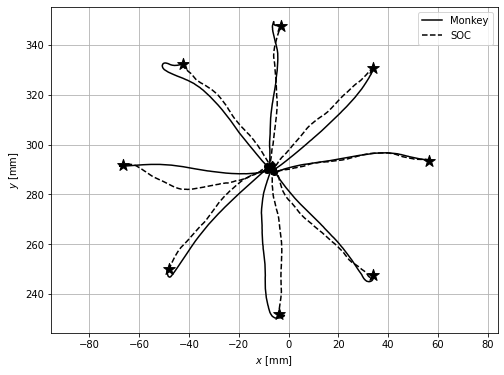

In [68]:
plot_comparison()